In [1]:
import os
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import ast
from tqdm import tqdm
from commons.model import KTPFormer
from commons.kps_dataset import MocapDataset
from commons.skeleton import Skeleton
from commons.graph_utils import adj_mx_from_skeleton
from commons.collate import custom_collate_fn
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from torch.utils.data import DataLoader, random_split
import warnings
from importlib import reload
from commons import mocap_dataset
reload(mocap_dataset)
from commons.mocap_dataset import MocapDataset
warnings.filterwarnings("ignore")
load_dotenv()

uri = os.getenv('URI')
if not uri:
    raise EnvironmentError("Please set the 'URI' environment variable in your .env file.")

### Functions

In [2]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
            
def weighted_frobenius_loss(pred, target):
    weight_matrix = torch.ones_like(target)
    weight_matrix[:, -1] = 0.1
    scale = torch.norm(target, p='fro', dim=1, keepdim=True) + 1e-6
    diff = weight_matrix * ((pred - target) / scale)
    loss = torch.norm(diff, p='fro') / target.size(0)
    return loss

def compute_metrics(outputs, targets):
    loss = weighted_frobenius_loss(outputs, targets)
    return loss


def sanity_check(dataset, num_samples=50):
    num_samples = min(num_samples, len(dataset))
    for idx in range(num_samples):
        keypoints = dataset[idx][0]
        camera_matrix = dataset[idx][1]
        labels = dataset[idx][2]
        label_idx = dataset[idx][3]
        assert keypoints.shape[0] == dataset.num_joints * 2, f"Sample {idx} keypoints shape mismatch"
        assert camera_matrix.shape[0] == 16, f"Sample {idx} camera matrix shape mismatch"
    print(f"Sanity check passed for {num_samples} samples.")

def visualize_predictions(outputs, targets, num_samples=2):
    num_samples = min(num_samples, outputs.shape[0])
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.plot(outputs[i], label='Prediction', marker='o', linestyle='--')
        plt.plot(targets[i], label='Target', marker='x', linestyle=':')
        plt.title(f"Sample {i + 1}")
        plt.legend()
        plt.grid()
    plt.tight_layout()
    plt.show()

def visualize_keypoint_skeleton(keypoints, skeleton):
    import matplotlib.pyplot as plt

    reshaped_keypoints = keypoints.reshape(-1, 2)
    fig, ax = plt.subplots(figsize=(8, 8))

    for child_idx, parent_idx in skeleton.get_connection_indices():
        if parent_idx != -1:
            x_vals = [reshaped_keypoints[child_idx, 0], reshaped_keypoints[parent_idx, 0]]
            y_vals = [reshaped_keypoints[child_idx, 1], reshaped_keypoints[parent_idx, 1]]
            print(x_vals)
            ax.plot(x_vals, y_vals, c='green', linewidth=2)
            # Debug: Print each connection
            print(f"Line: {skeleton._joint_names[child_idx]} -> {skeleton._joint_names[parent_idx]} | "
                  f"Points: {x_vals}, {y_vals}")

    ax.scatter(reshaped_keypoints[:, 0], reshaped_keypoints[:, 1], c='blue', marker='x', label='Joints')
    for idx, (x, y) in enumerate(reshaped_keypoints):
        ax.text(x, y, skeleton._joint_names[idx], size=8, color='k')

    ax.set_title("2D Skeleton Visualization")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.invert_yaxis()  
    ax.axis('equal')
    plt.tight_layout()
    plt.show()


## Main

Data Fraction: 0.001, Using 513 samples out of 513253.
Number of joints: 31
Joint names: ['Chest', 'Head', 'HeadEnd', 'Hips', 'LeftArm', 'LeftFinger', 'LeftFingerEnd', 'LeftFoot', 'LeftForearm', 'LeftHand', 'LeftHeel', 'LeftLeg', 'LeftShoulder', 'LeftThigh', 'LeftToe', 'LeftToeEnd', 'Neck', 'RightArm', 'RightFinger', 'RightFingerEnd', 'RightFoot', 'RightForearm', 'RightHand', 'RightHeel', 'RightLeg', 'RightShoulder', 'RightThigh', 'RightToe', 'RightToeEnd', 'SpineLow', 'SpineMid']
Sanity check passed for 50 samples.
Training samples: 359
Validation samples: 51
Testing samples: 103


Epoch 1/20: 100%|██████████| 2/2 [00:07<00:00,  3.85s/it, loss=0.0983]


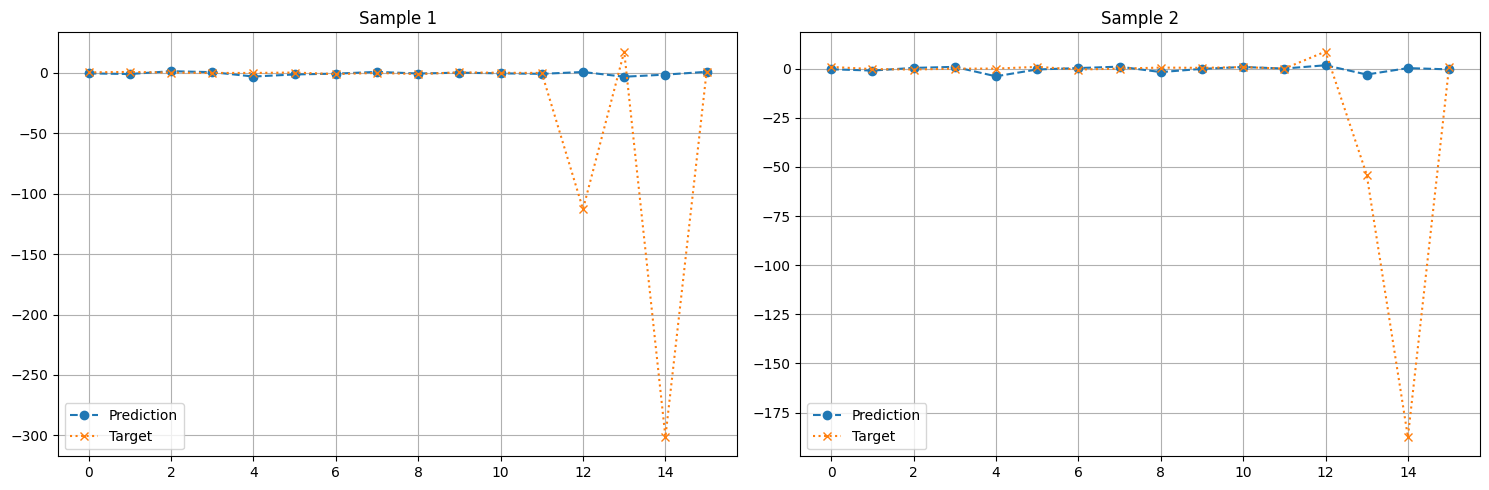

[np.float32(2058.153), np.float32(1981.5721)]
Line: Head -> Neck | Points: [np.float32(2058.153), np.float32(1981.5721)], [np.float32(870.6599), np.float32(971.6488)]
[np.float32(1981.5721), np.float32(1856.2484)]
Line: Neck -> Chest | Points: [np.float32(1981.5721), np.float32(1856.2484)], [np.float32(971.6488), np.float32(1074.105)]
[np.float32(1856.2484), np.float32(1776.7876)]
Line: Chest -> Hips | Points: [np.float32(1856.2484), np.float32(1776.7876)], [np.float32(1074.105), np.float32(1325.7881)]
[np.float32(1981.5721), np.float32(1948.6613)]
Line: Neck -> LeftShoulder | Points: [np.float32(1981.5721), np.float32(1948.6613)], [np.float32(971.6488), np.float32(938.1341)]
[np.float32(1948.6613), np.float32(1868.0879)]
Line: LeftShoulder -> LeftArm | Points: [np.float32(1948.6613), np.float32(1868.0879)], [np.float32(938.1341), np.float32(835.4595)]
[np.float32(1868.0879), np.float32(1728.0599)]
Line: LeftArm -> LeftForearm | Points: [np.float32(1868.0879), np.float32(1728.0599)], [

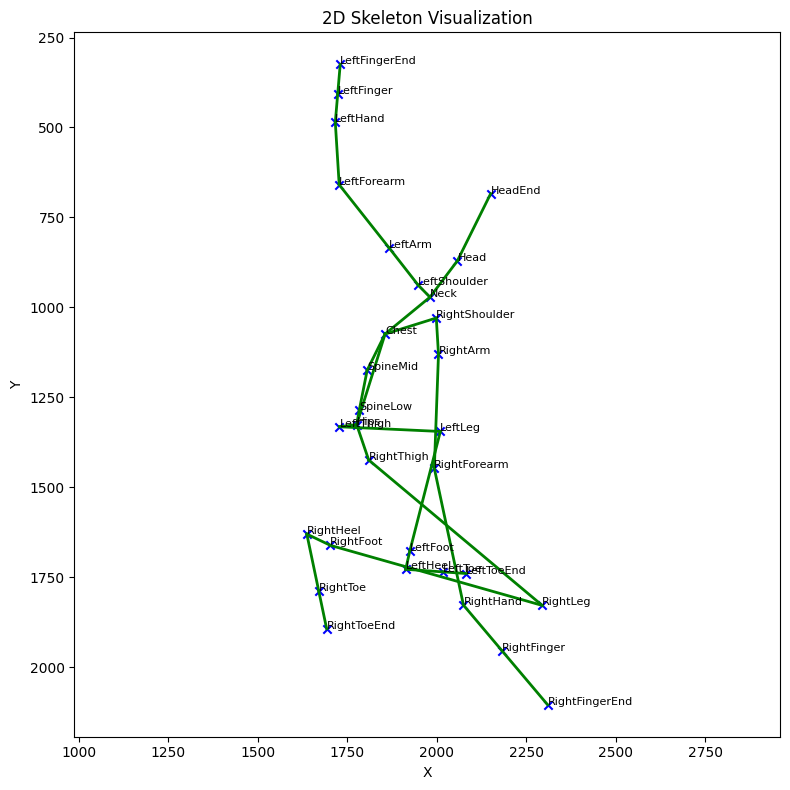

Epoch 1/20 Summary:
  Training Loss: 0.0802
  Validation Loss: 0.1395
  Model saved with validation loss: 0.1395


Epoch 2/20: 100%|██████████| 2/2 [00:07<00:00,  3.92s/it, loss=0.0967]


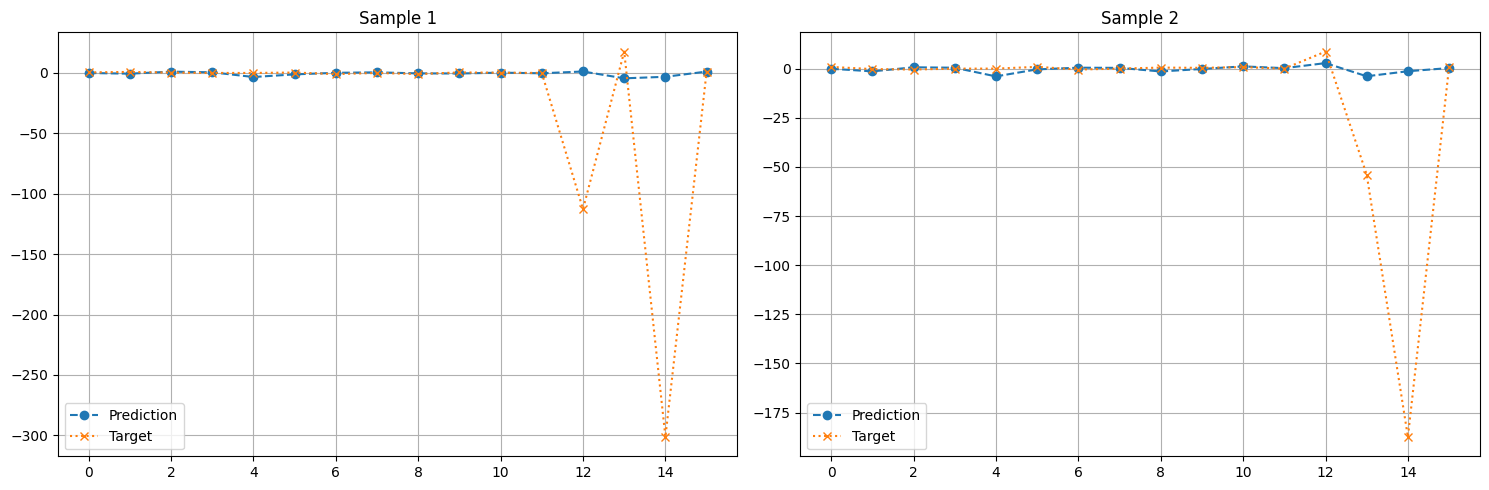

[np.float32(2058.153), np.float32(1981.5721)]
Line: Head -> Neck | Points: [np.float32(2058.153), np.float32(1981.5721)], [np.float32(870.6599), np.float32(971.6488)]
[np.float32(1981.5721), np.float32(1856.2484)]
Line: Neck -> Chest | Points: [np.float32(1981.5721), np.float32(1856.2484)], [np.float32(971.6488), np.float32(1074.105)]
[np.float32(1856.2484), np.float32(1776.7876)]
Line: Chest -> Hips | Points: [np.float32(1856.2484), np.float32(1776.7876)], [np.float32(1074.105), np.float32(1325.7881)]
[np.float32(1981.5721), np.float32(1948.6613)]
Line: Neck -> LeftShoulder | Points: [np.float32(1981.5721), np.float32(1948.6613)], [np.float32(971.6488), np.float32(938.1341)]
[np.float32(1948.6613), np.float32(1868.0879)]
Line: LeftShoulder -> LeftArm | Points: [np.float32(1948.6613), np.float32(1868.0879)], [np.float32(938.1341), np.float32(835.4595)]
[np.float32(1868.0879), np.float32(1728.0599)]
Line: LeftArm -> LeftForearm | Points: [np.float32(1868.0879), np.float32(1728.0599)], [

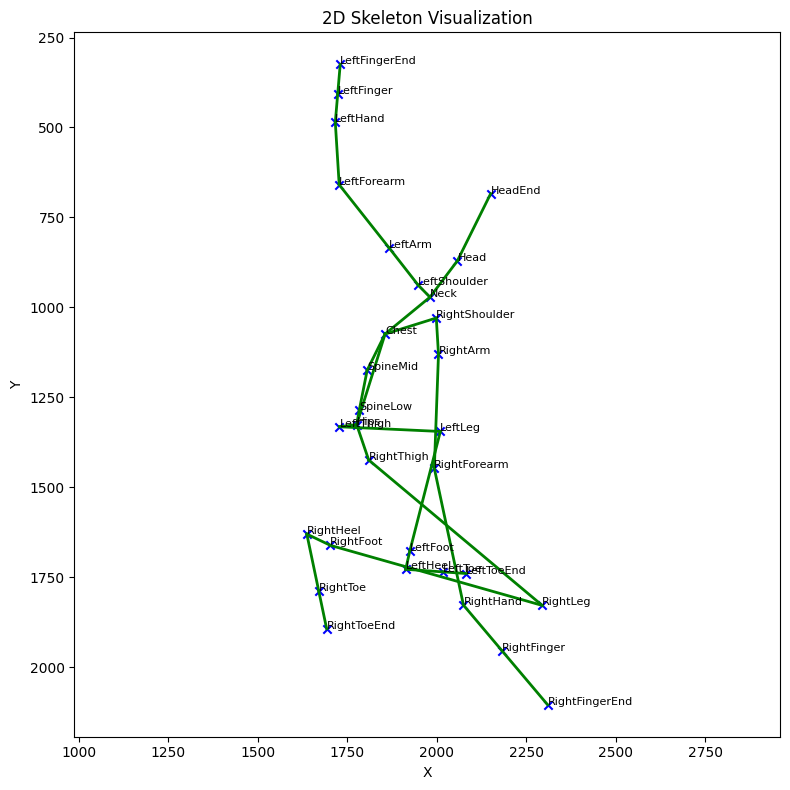

Epoch 2/20 Summary:
  Training Loss: 0.0794
  Validation Loss: 0.1383
  Model saved with validation loss: 0.1383


Epoch 3/20: 100%|██████████| 2/2 [00:07<00:00,  4.00s/it, loss=0.096] 


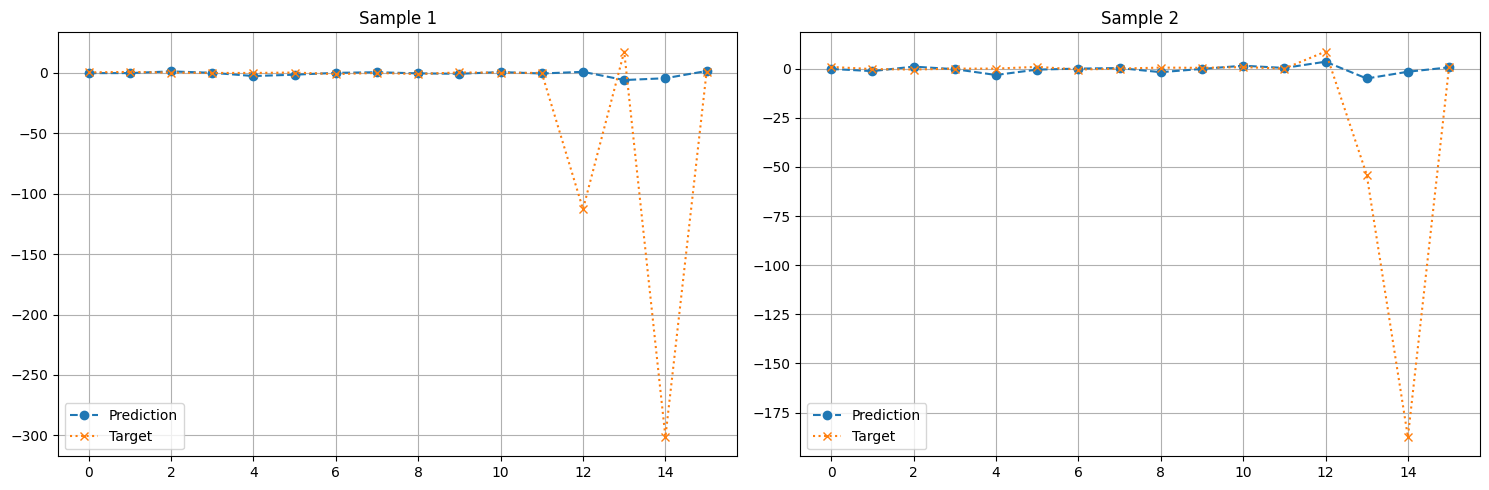

[np.float32(2058.153), np.float32(1981.5721)]
Line: Head -> Neck | Points: [np.float32(2058.153), np.float32(1981.5721)], [np.float32(870.6599), np.float32(971.6488)]
[np.float32(1981.5721), np.float32(1856.2484)]
Line: Neck -> Chest | Points: [np.float32(1981.5721), np.float32(1856.2484)], [np.float32(971.6488), np.float32(1074.105)]
[np.float32(1856.2484), np.float32(1776.7876)]
Line: Chest -> Hips | Points: [np.float32(1856.2484), np.float32(1776.7876)], [np.float32(1074.105), np.float32(1325.7881)]
[np.float32(1981.5721), np.float32(1948.6613)]
Line: Neck -> LeftShoulder | Points: [np.float32(1981.5721), np.float32(1948.6613)], [np.float32(971.6488), np.float32(938.1341)]
[np.float32(1948.6613), np.float32(1868.0879)]
Line: LeftShoulder -> LeftArm | Points: [np.float32(1948.6613), np.float32(1868.0879)], [np.float32(938.1341), np.float32(835.4595)]
[np.float32(1868.0879), np.float32(1728.0599)]
Line: LeftArm -> LeftForearm | Points: [np.float32(1868.0879), np.float32(1728.0599)], [

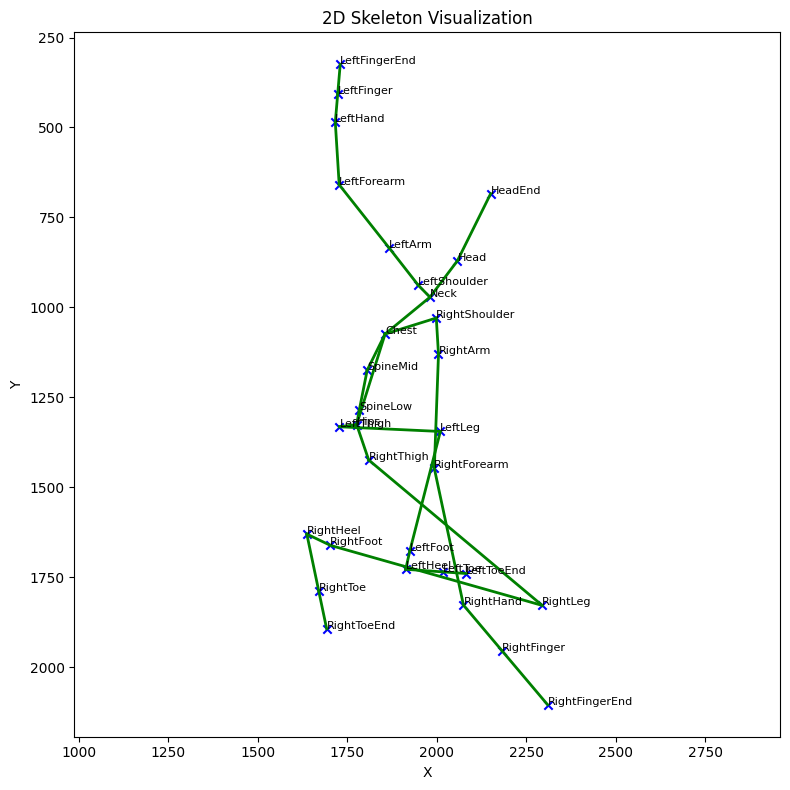

Epoch 3/20 Summary:
  Training Loss: 0.0789
  Validation Loss: 0.1378
  Model saved with validation loss: 0.1378


Epoch 4/20: 100%|██████████| 2/2 [00:07<00:00,  3.94s/it, loss=0.0953]


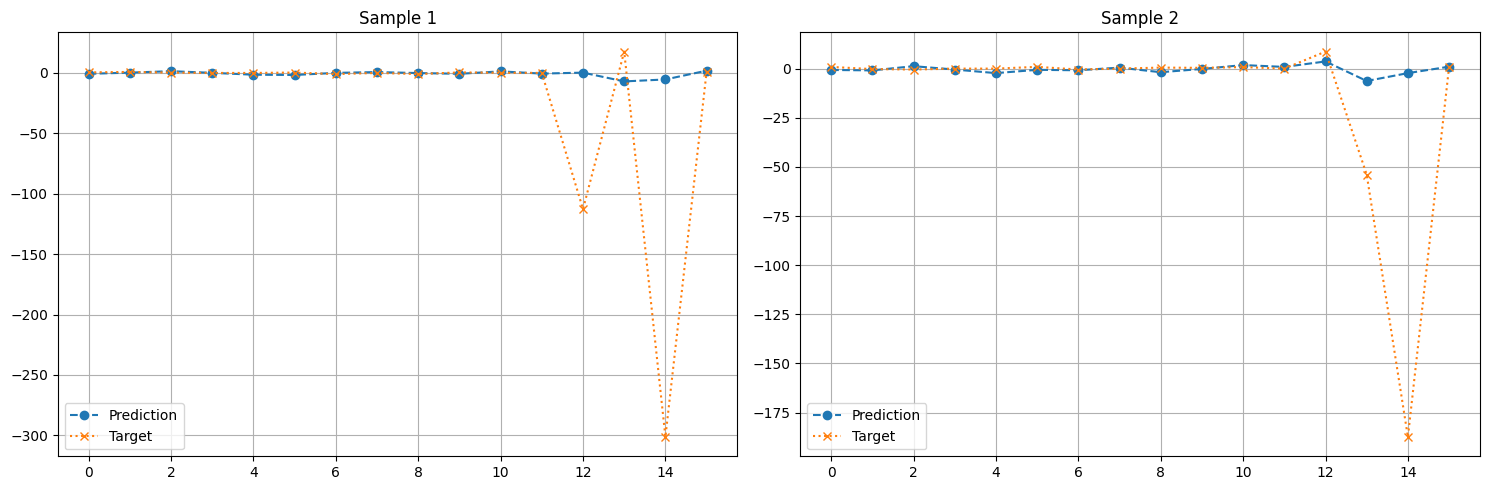

[np.float32(2058.153), np.float32(1981.5721)]
Line: Head -> Neck | Points: [np.float32(2058.153), np.float32(1981.5721)], [np.float32(870.6599), np.float32(971.6488)]
[np.float32(1981.5721), np.float32(1856.2484)]
Line: Neck -> Chest | Points: [np.float32(1981.5721), np.float32(1856.2484)], [np.float32(971.6488), np.float32(1074.105)]
[np.float32(1856.2484), np.float32(1776.7876)]
Line: Chest -> Hips | Points: [np.float32(1856.2484), np.float32(1776.7876)], [np.float32(1074.105), np.float32(1325.7881)]
[np.float32(1981.5721), np.float32(1948.6613)]
Line: Neck -> LeftShoulder | Points: [np.float32(1981.5721), np.float32(1948.6613)], [np.float32(971.6488), np.float32(938.1341)]
[np.float32(1948.6613), np.float32(1868.0879)]
Line: LeftShoulder -> LeftArm | Points: [np.float32(1948.6613), np.float32(1868.0879)], [np.float32(938.1341), np.float32(835.4595)]
[np.float32(1868.0879), np.float32(1728.0599)]
Line: LeftArm -> LeftForearm | Points: [np.float32(1868.0879), np.float32(1728.0599)], [

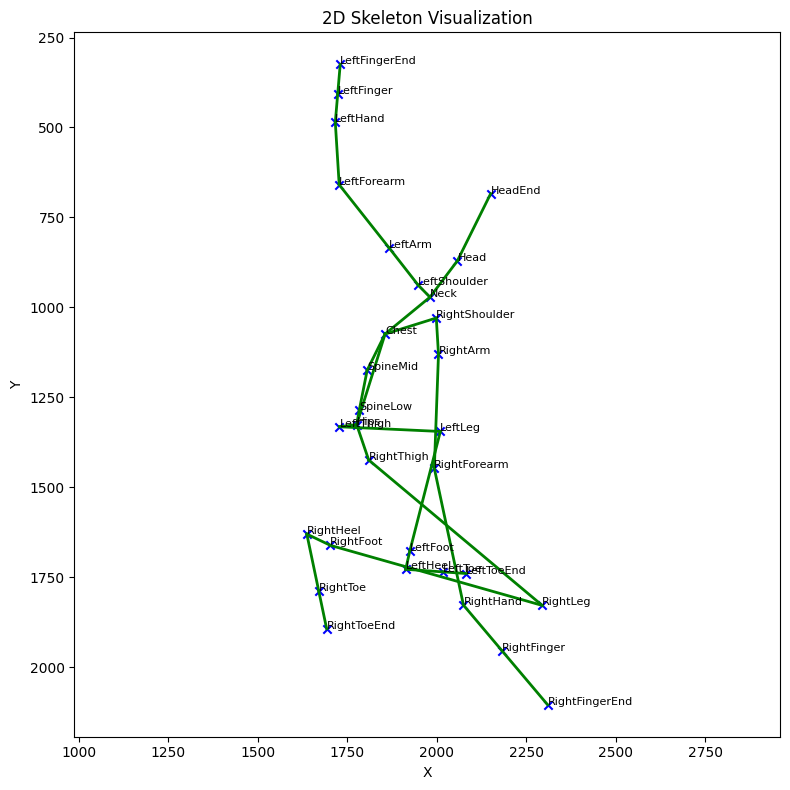

Epoch 4/20 Summary:
  Training Loss: 0.0782
  Validation Loss: 0.1372
  Model saved with validation loss: 0.1372


Epoch 5/20: 100%|██████████| 2/2 [00:07<00:00,  3.91s/it, loss=0.0948]


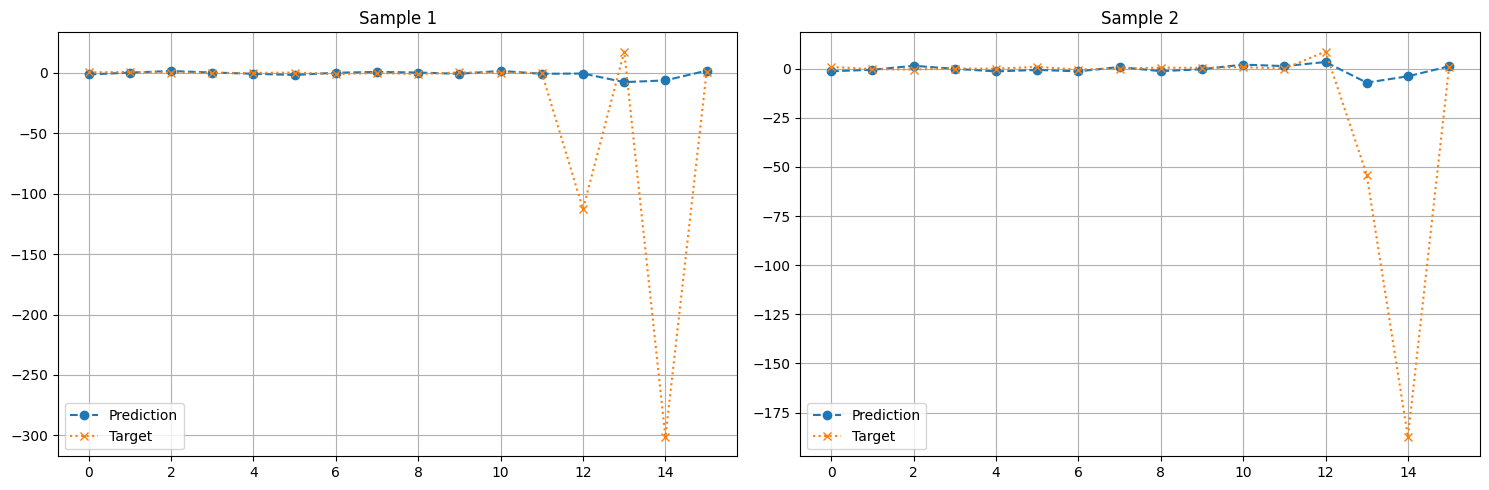

[np.float32(2058.153), np.float32(1981.5721)]
Line: Head -> Neck | Points: [np.float32(2058.153), np.float32(1981.5721)], [np.float32(870.6599), np.float32(971.6488)]
[np.float32(1981.5721), np.float32(1856.2484)]
Line: Neck -> Chest | Points: [np.float32(1981.5721), np.float32(1856.2484)], [np.float32(971.6488), np.float32(1074.105)]
[np.float32(1856.2484), np.float32(1776.7876)]
Line: Chest -> Hips | Points: [np.float32(1856.2484), np.float32(1776.7876)], [np.float32(1074.105), np.float32(1325.7881)]
[np.float32(1981.5721), np.float32(1948.6613)]
Line: Neck -> LeftShoulder | Points: [np.float32(1981.5721), np.float32(1948.6613)], [np.float32(971.6488), np.float32(938.1341)]
[np.float32(1948.6613), np.float32(1868.0879)]
Line: LeftShoulder -> LeftArm | Points: [np.float32(1948.6613), np.float32(1868.0879)], [np.float32(938.1341), np.float32(835.4595)]
[np.float32(1868.0879), np.float32(1728.0599)]
Line: LeftArm -> LeftForearm | Points: [np.float32(1868.0879), np.float32(1728.0599)], [

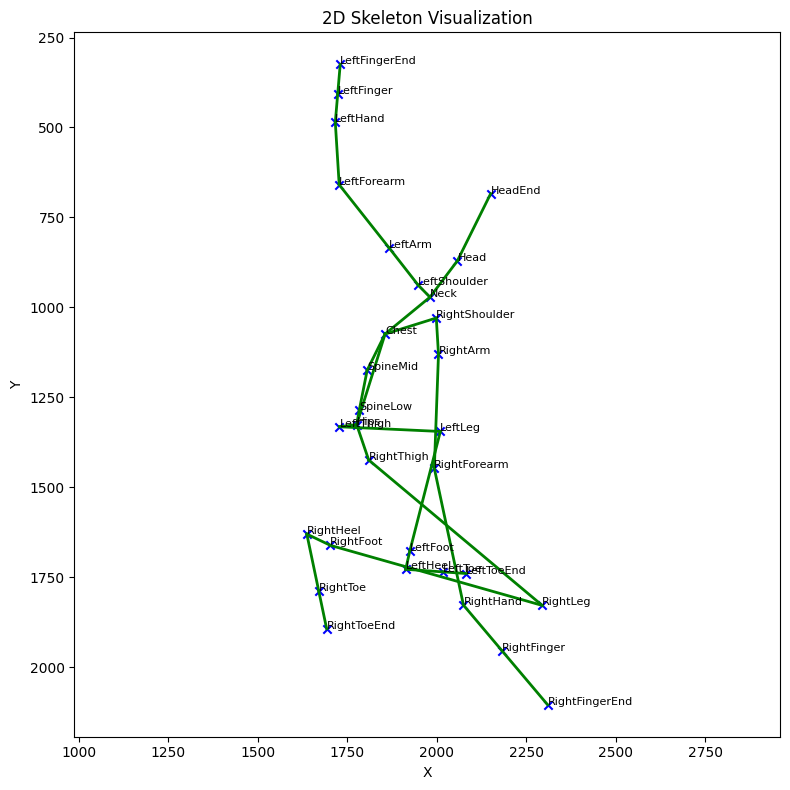

Epoch 5/20 Summary:
  Training Loss: 0.0778
  Validation Loss: 0.1364
  Model saved with validation loss: 0.1364


Epoch 6/20: 100%|██████████| 2/2 [00:08<00:00,  4.00s/it, loss=0.095] 


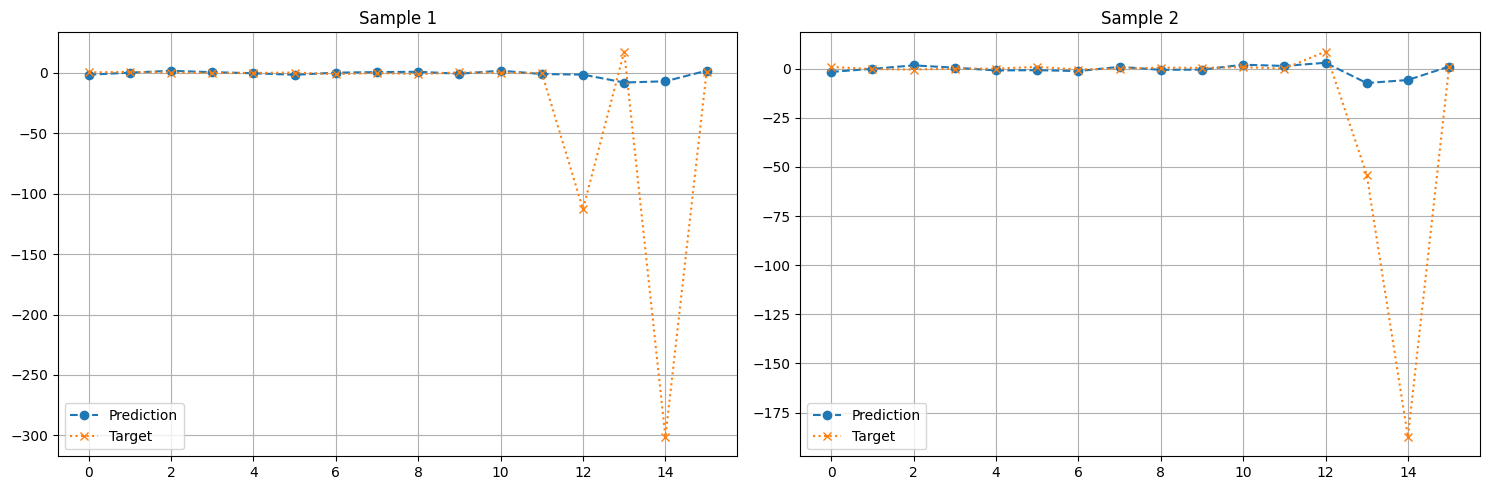

[np.float32(2058.153), np.float32(1981.5721)]
Line: Head -> Neck | Points: [np.float32(2058.153), np.float32(1981.5721)], [np.float32(870.6599), np.float32(971.6488)]
[np.float32(1981.5721), np.float32(1856.2484)]
Line: Neck -> Chest | Points: [np.float32(1981.5721), np.float32(1856.2484)], [np.float32(971.6488), np.float32(1074.105)]
[np.float32(1856.2484), np.float32(1776.7876)]
Line: Chest -> Hips | Points: [np.float32(1856.2484), np.float32(1776.7876)], [np.float32(1074.105), np.float32(1325.7881)]
[np.float32(1981.5721), np.float32(1948.6613)]
Line: Neck -> LeftShoulder | Points: [np.float32(1981.5721), np.float32(1948.6613)], [np.float32(971.6488), np.float32(938.1341)]
[np.float32(1948.6613), np.float32(1868.0879)]
Line: LeftShoulder -> LeftArm | Points: [np.float32(1948.6613), np.float32(1868.0879)], [np.float32(938.1341), np.float32(835.4595)]
[np.float32(1868.0879), np.float32(1728.0599)]
Line: LeftArm -> LeftForearm | Points: [np.float32(1868.0879), np.float32(1728.0599)], [

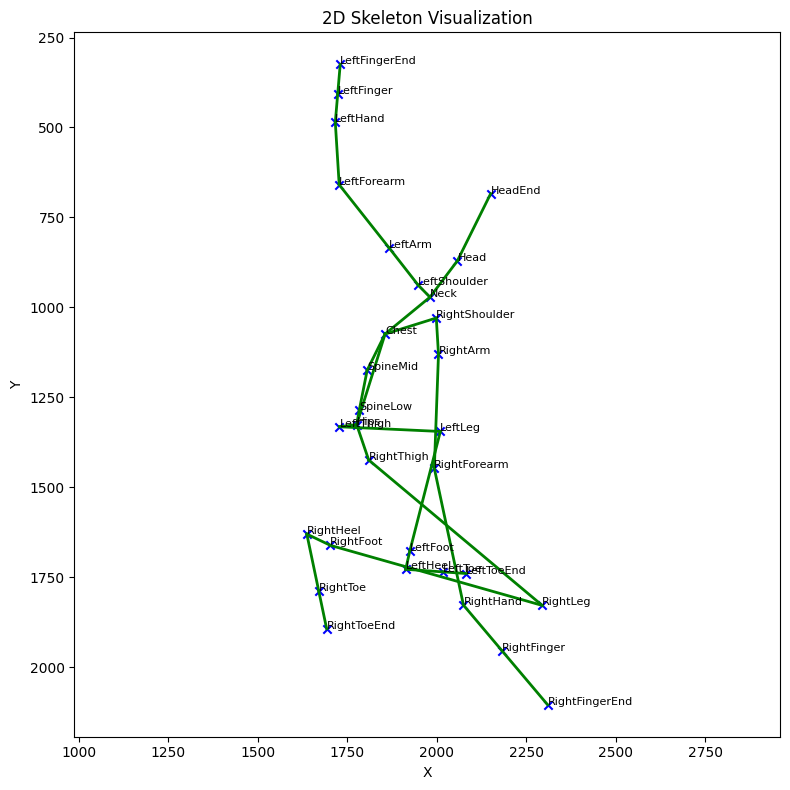

Epoch 6/20 Summary:
  Training Loss: 0.0775
  Validation Loss: 0.1356
  Model saved with validation loss: 0.1356


Epoch 7/20: 100%|██████████| 2/2 [00:08<00:00,  4.05s/it, loss=0.0962]


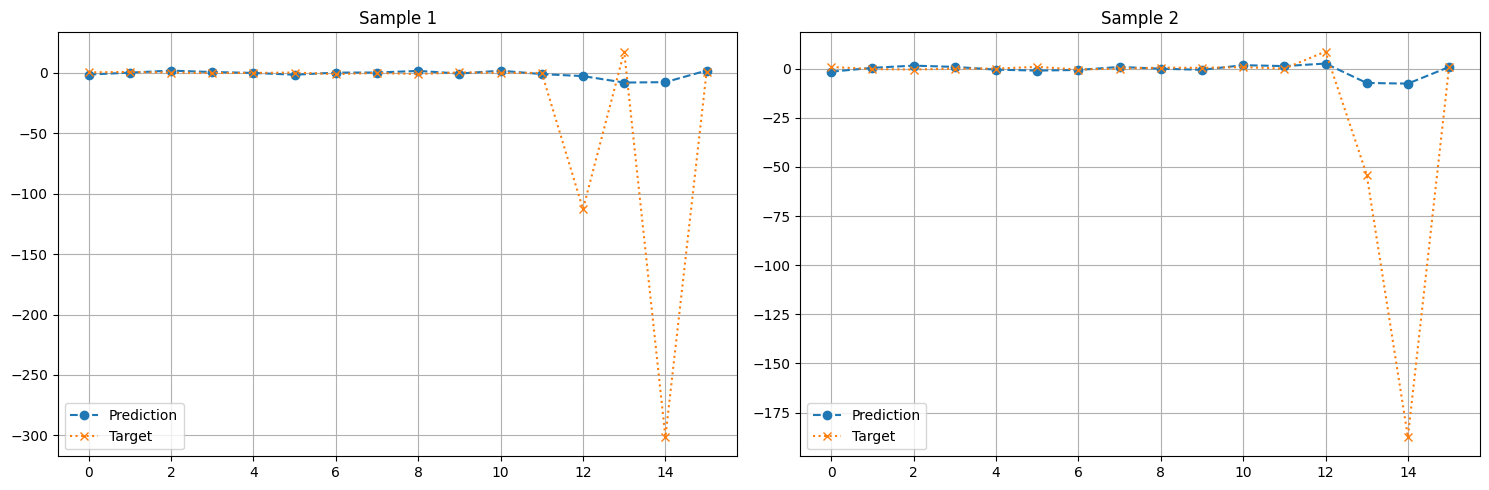

[np.float32(2058.153), np.float32(1981.5721)]
Line: Head -> Neck | Points: [np.float32(2058.153), np.float32(1981.5721)], [np.float32(870.6599), np.float32(971.6488)]
[np.float32(1981.5721), np.float32(1856.2484)]
Line: Neck -> Chest | Points: [np.float32(1981.5721), np.float32(1856.2484)], [np.float32(971.6488), np.float32(1074.105)]
[np.float32(1856.2484), np.float32(1776.7876)]
Line: Chest -> Hips | Points: [np.float32(1856.2484), np.float32(1776.7876)], [np.float32(1074.105), np.float32(1325.7881)]
[np.float32(1981.5721), np.float32(1948.6613)]
Line: Neck -> LeftShoulder | Points: [np.float32(1981.5721), np.float32(1948.6613)], [np.float32(971.6488), np.float32(938.1341)]
[np.float32(1948.6613), np.float32(1868.0879)]
Line: LeftShoulder -> LeftArm | Points: [np.float32(1948.6613), np.float32(1868.0879)], [np.float32(938.1341), np.float32(835.4595)]
[np.float32(1868.0879), np.float32(1728.0599)]
Line: LeftArm -> LeftForearm | Points: [np.float32(1868.0879), np.float32(1728.0599)], [

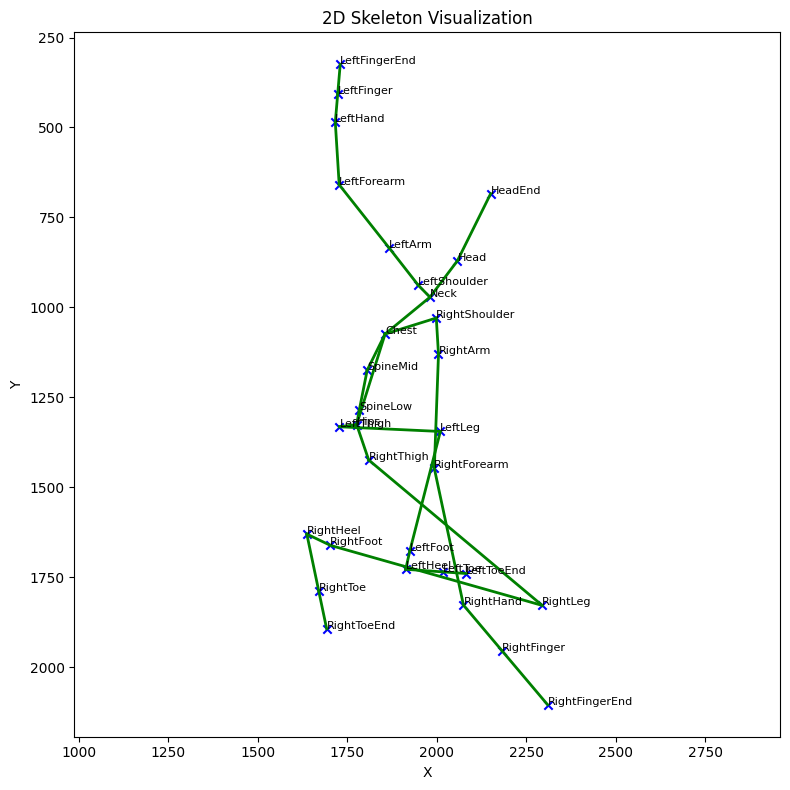

Epoch 7/20 Summary:
  Training Loss: 0.0780
  Validation Loss: 0.1348
  Model saved with validation loss: 0.1348


Epoch 8/20: 100%|██████████| 2/2 [00:08<00:00,  4.01s/it, loss=0.0963]


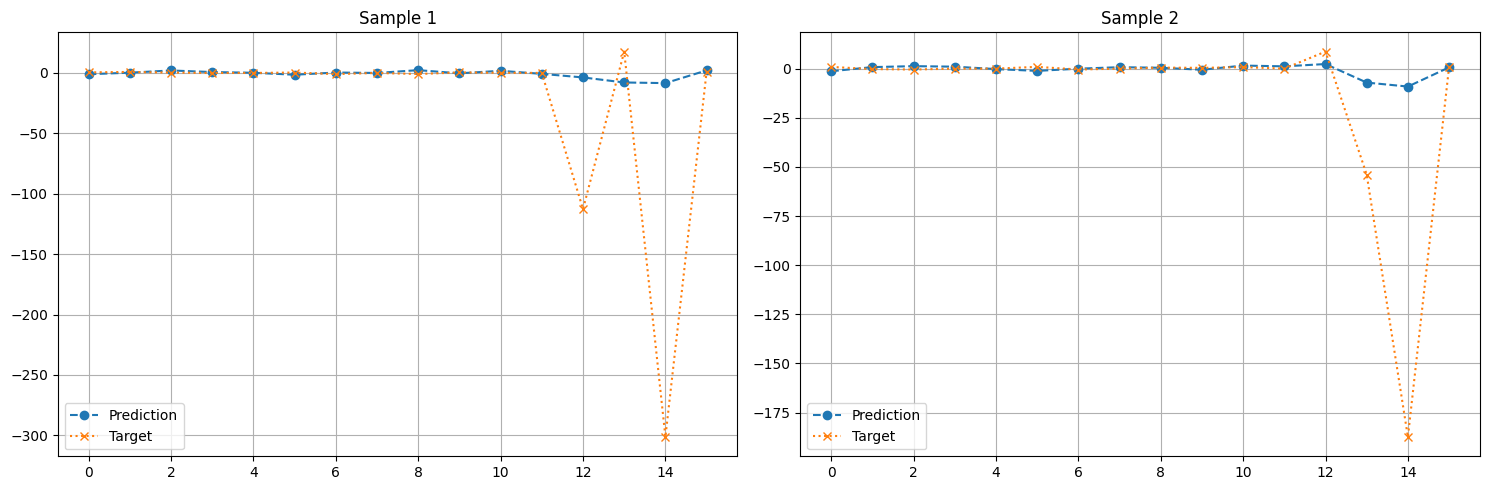

[np.float32(2058.153), np.float32(1981.5721)]
Line: Head -> Neck | Points: [np.float32(2058.153), np.float32(1981.5721)], [np.float32(870.6599), np.float32(971.6488)]
[np.float32(1981.5721), np.float32(1856.2484)]
Line: Neck -> Chest | Points: [np.float32(1981.5721), np.float32(1856.2484)], [np.float32(971.6488), np.float32(1074.105)]
[np.float32(1856.2484), np.float32(1776.7876)]
Line: Chest -> Hips | Points: [np.float32(1856.2484), np.float32(1776.7876)], [np.float32(1074.105), np.float32(1325.7881)]
[np.float32(1981.5721), np.float32(1948.6613)]
Line: Neck -> LeftShoulder | Points: [np.float32(1981.5721), np.float32(1948.6613)], [np.float32(971.6488), np.float32(938.1341)]
[np.float32(1948.6613), np.float32(1868.0879)]
Line: LeftShoulder -> LeftArm | Points: [np.float32(1948.6613), np.float32(1868.0879)], [np.float32(938.1341), np.float32(835.4595)]
[np.float32(1868.0879), np.float32(1728.0599)]
Line: LeftArm -> LeftForearm | Points: [np.float32(1868.0879), np.float32(1728.0599)], [

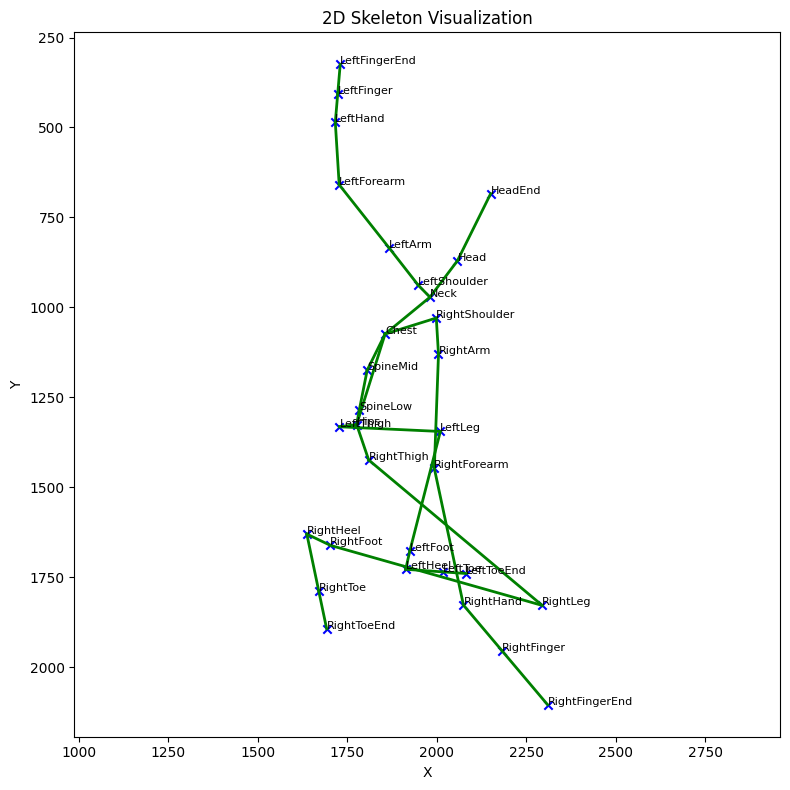

Epoch 8/20 Summary:
  Training Loss: 0.0779
  Validation Loss: 0.1341
  Model saved with validation loss: 0.1341


Epoch 9/20: 100%|██████████| 2/2 [00:08<00:00,  4.21s/it, loss=0.0943]


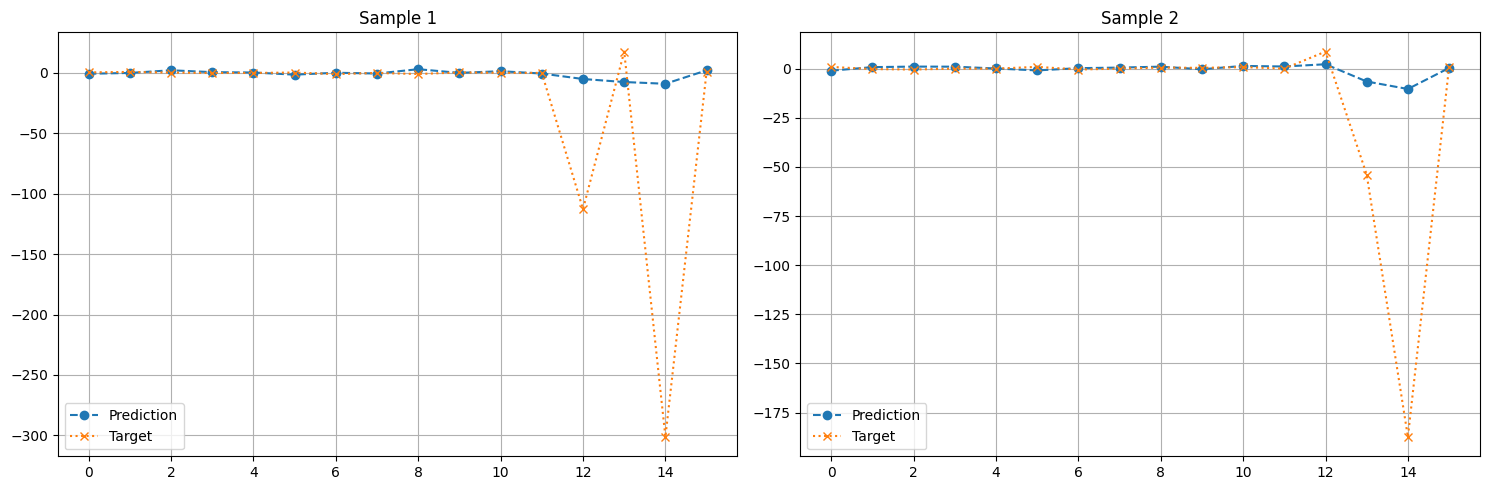

[np.float32(2058.153), np.float32(1981.5721)]
Line: Head -> Neck | Points: [np.float32(2058.153), np.float32(1981.5721)], [np.float32(870.6599), np.float32(971.6488)]
[np.float32(1981.5721), np.float32(1856.2484)]
Line: Neck -> Chest | Points: [np.float32(1981.5721), np.float32(1856.2484)], [np.float32(971.6488), np.float32(1074.105)]
[np.float32(1856.2484), np.float32(1776.7876)]
Line: Chest -> Hips | Points: [np.float32(1856.2484), np.float32(1776.7876)], [np.float32(1074.105), np.float32(1325.7881)]
[np.float32(1981.5721), np.float32(1948.6613)]
Line: Neck -> LeftShoulder | Points: [np.float32(1981.5721), np.float32(1948.6613)], [np.float32(971.6488), np.float32(938.1341)]
[np.float32(1948.6613), np.float32(1868.0879)]
Line: LeftShoulder -> LeftArm | Points: [np.float32(1948.6613), np.float32(1868.0879)], [np.float32(938.1341), np.float32(835.4595)]
[np.float32(1868.0879), np.float32(1728.0599)]
Line: LeftArm -> LeftForearm | Points: [np.float32(1868.0879), np.float32(1728.0599)], [

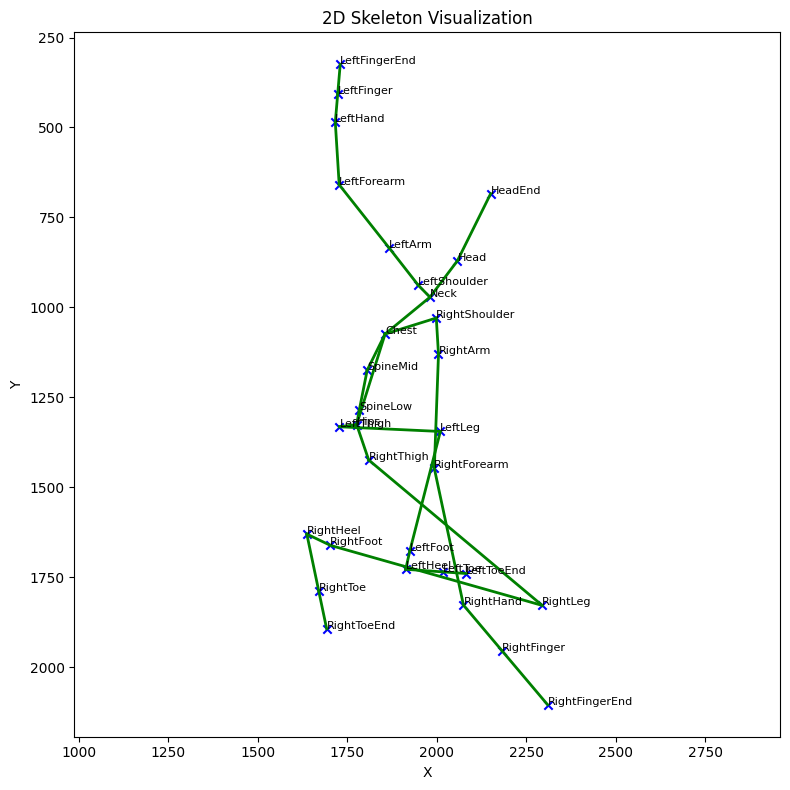

Epoch 9/20 Summary:
  Training Loss: 0.0768
  Validation Loss: 0.1335
  Model saved with validation loss: 0.1335


Epoch 10/20: 100%|██████████| 2/2 [00:07<00:00,  3.99s/it, loss=0.0936]


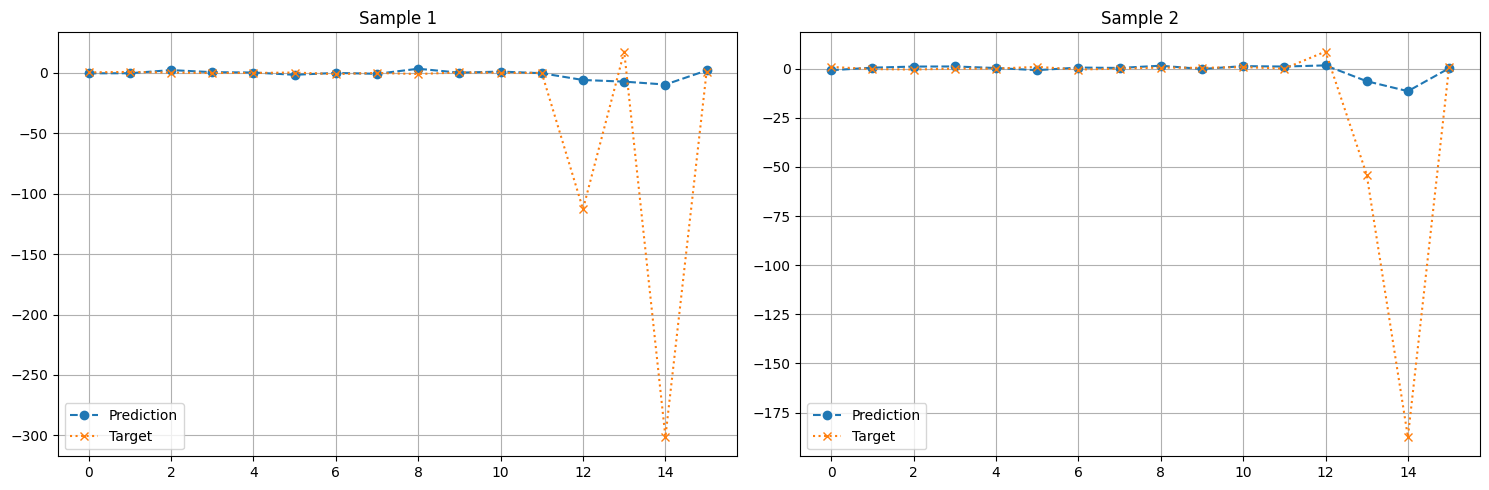

[np.float32(2058.153), np.float32(1981.5721)]
Line: Head -> Neck | Points: [np.float32(2058.153), np.float32(1981.5721)], [np.float32(870.6599), np.float32(971.6488)]
[np.float32(1981.5721), np.float32(1856.2484)]
Line: Neck -> Chest | Points: [np.float32(1981.5721), np.float32(1856.2484)], [np.float32(971.6488), np.float32(1074.105)]
[np.float32(1856.2484), np.float32(1776.7876)]
Line: Chest -> Hips | Points: [np.float32(1856.2484), np.float32(1776.7876)], [np.float32(1074.105), np.float32(1325.7881)]
[np.float32(1981.5721), np.float32(1948.6613)]
Line: Neck -> LeftShoulder | Points: [np.float32(1981.5721), np.float32(1948.6613)], [np.float32(971.6488), np.float32(938.1341)]
[np.float32(1948.6613), np.float32(1868.0879)]
Line: LeftShoulder -> LeftArm | Points: [np.float32(1948.6613), np.float32(1868.0879)], [np.float32(938.1341), np.float32(835.4595)]
[np.float32(1868.0879), np.float32(1728.0599)]
Line: LeftArm -> LeftForearm | Points: [np.float32(1868.0879), np.float32(1728.0599)], [

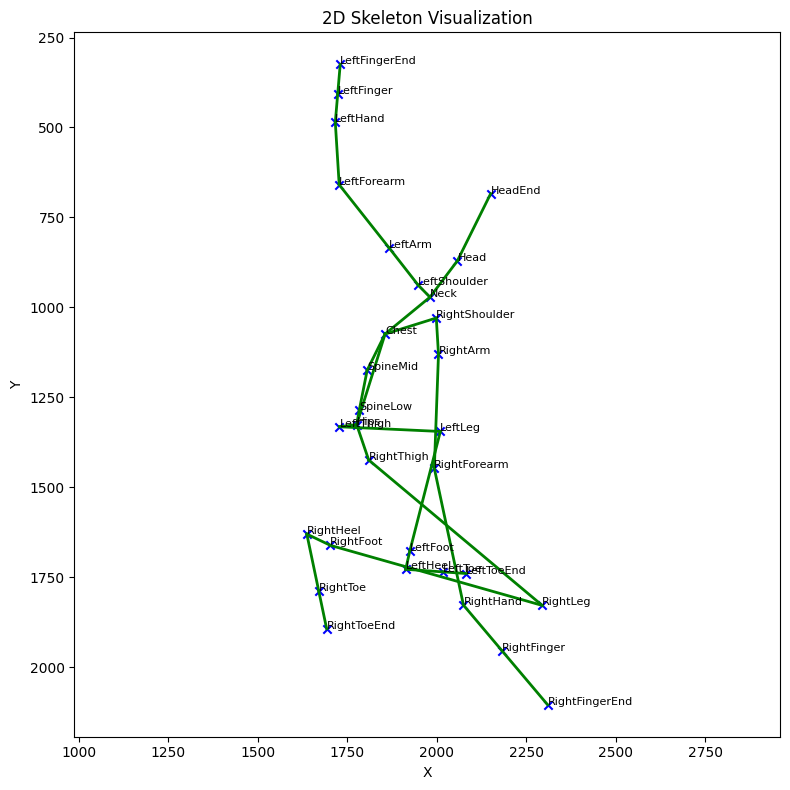

Epoch 10/20 Summary:
  Training Loss: 0.0768
  Validation Loss: 0.1329
  Model saved with validation loss: 0.1329


Epoch 11/20: 100%|██████████| 2/2 [00:08<00:00,  4.08s/it, loss=0.0937]


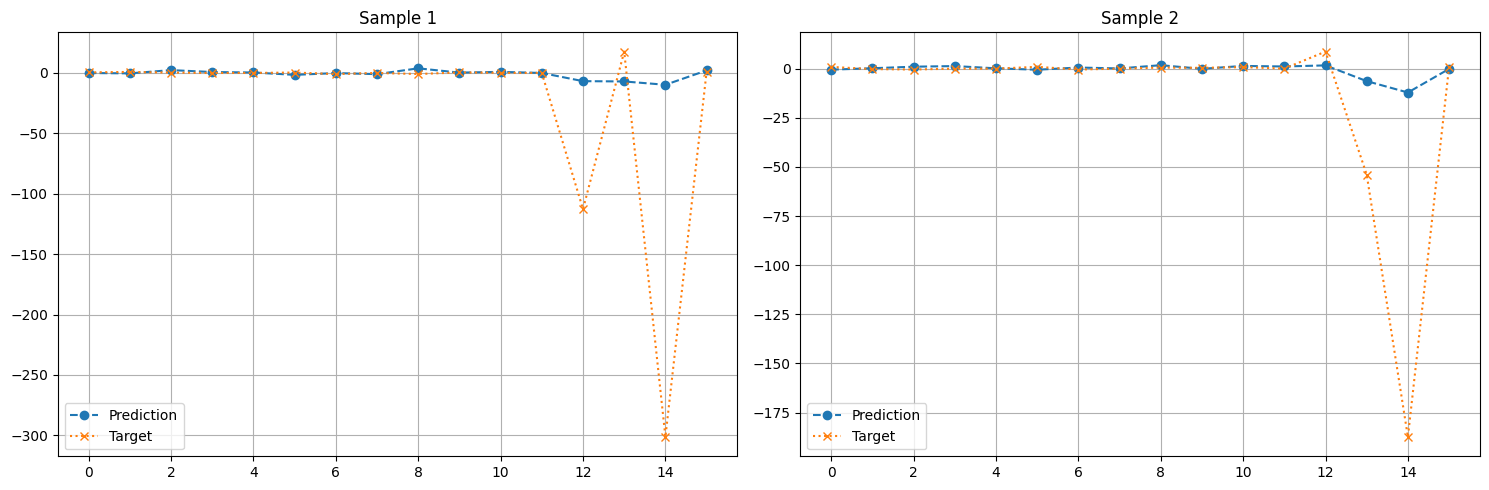

[np.float32(2058.153), np.float32(1981.5721)]
Line: Head -> Neck | Points: [np.float32(2058.153), np.float32(1981.5721)], [np.float32(870.6599), np.float32(971.6488)]
[np.float32(1981.5721), np.float32(1856.2484)]
Line: Neck -> Chest | Points: [np.float32(1981.5721), np.float32(1856.2484)], [np.float32(971.6488), np.float32(1074.105)]
[np.float32(1856.2484), np.float32(1776.7876)]
Line: Chest -> Hips | Points: [np.float32(1856.2484), np.float32(1776.7876)], [np.float32(1074.105), np.float32(1325.7881)]
[np.float32(1981.5721), np.float32(1948.6613)]
Line: Neck -> LeftShoulder | Points: [np.float32(1981.5721), np.float32(1948.6613)], [np.float32(971.6488), np.float32(938.1341)]
[np.float32(1948.6613), np.float32(1868.0879)]
Line: LeftShoulder -> LeftArm | Points: [np.float32(1948.6613), np.float32(1868.0879)], [np.float32(938.1341), np.float32(835.4595)]
[np.float32(1868.0879), np.float32(1728.0599)]
Line: LeftArm -> LeftForearm | Points: [np.float32(1868.0879), np.float32(1728.0599)], [

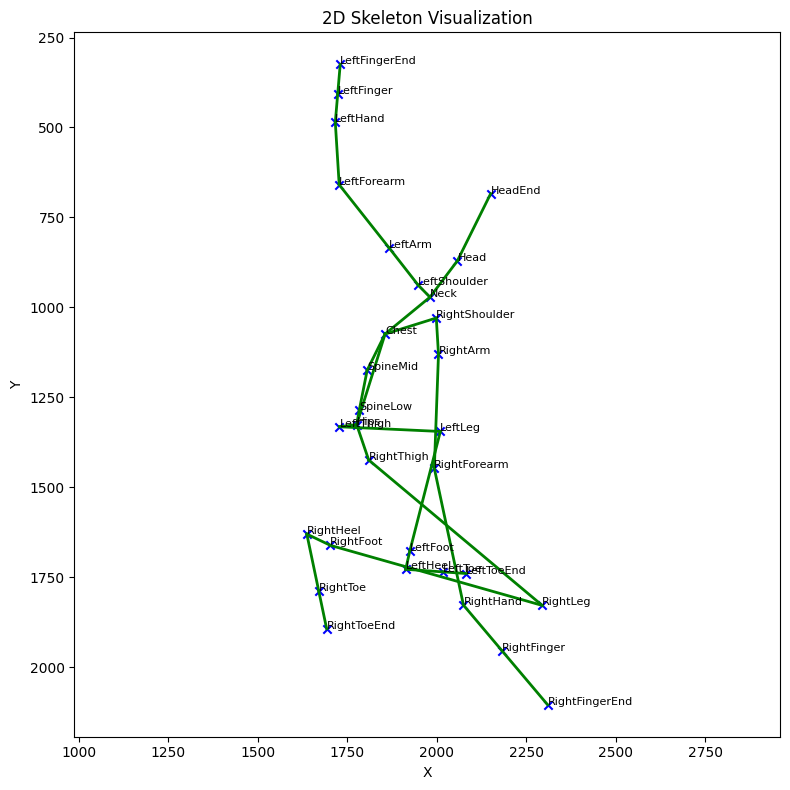

Epoch 11/20 Summary:
  Training Loss: 0.0763
  Validation Loss: 0.1326
  Model saved with validation loss: 0.1326


Epoch 12/20: 100%|██████████| 2/2 [00:08<00:00,  4.27s/it, loss=0.0932]


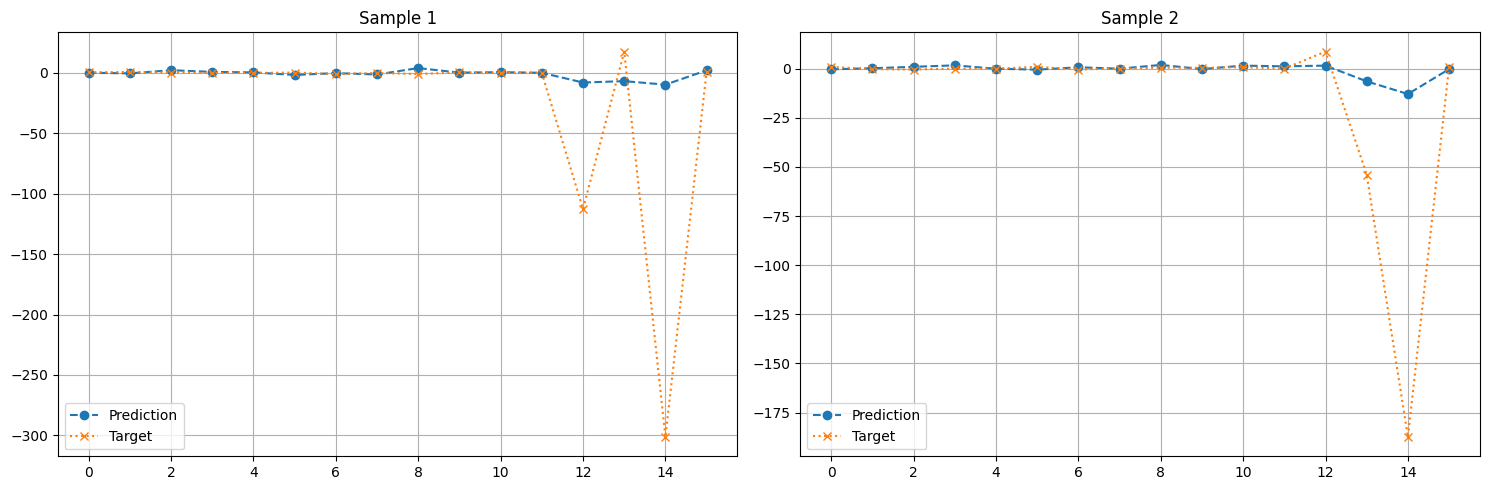

[np.float32(2058.153), np.float32(1981.5721)]
Line: Head -> Neck | Points: [np.float32(2058.153), np.float32(1981.5721)], [np.float32(870.6599), np.float32(971.6488)]
[np.float32(1981.5721), np.float32(1856.2484)]
Line: Neck -> Chest | Points: [np.float32(1981.5721), np.float32(1856.2484)], [np.float32(971.6488), np.float32(1074.105)]
[np.float32(1856.2484), np.float32(1776.7876)]
Line: Chest -> Hips | Points: [np.float32(1856.2484), np.float32(1776.7876)], [np.float32(1074.105), np.float32(1325.7881)]
[np.float32(1981.5721), np.float32(1948.6613)]
Line: Neck -> LeftShoulder | Points: [np.float32(1981.5721), np.float32(1948.6613)], [np.float32(971.6488), np.float32(938.1341)]
[np.float32(1948.6613), np.float32(1868.0879)]
Line: LeftShoulder -> LeftArm | Points: [np.float32(1948.6613), np.float32(1868.0879)], [np.float32(938.1341), np.float32(835.4595)]
[np.float32(1868.0879), np.float32(1728.0599)]
Line: LeftArm -> LeftForearm | Points: [np.float32(1868.0879), np.float32(1728.0599)], [

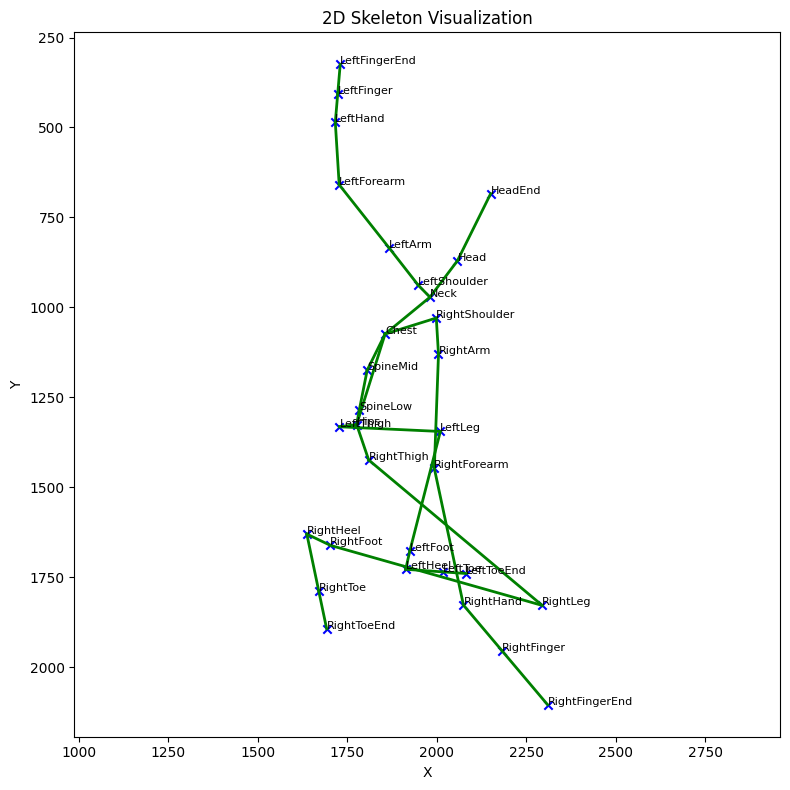

Epoch 12/20 Summary:
  Training Loss: 0.0761
  Validation Loss: 0.1322
  Model saved with validation loss: 0.1322


Epoch 13/20: 100%|██████████| 2/2 [00:07<00:00,  3.97s/it, loss=0.0939]


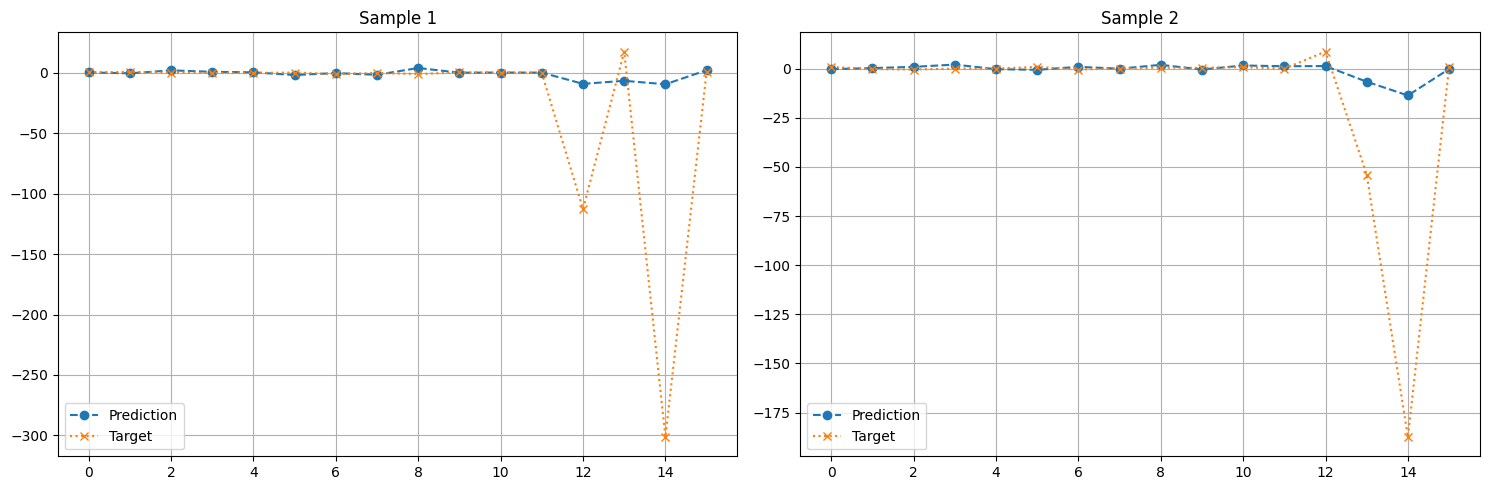

[np.float32(2058.153), np.float32(1981.5721)]
Line: Head -> Neck | Points: [np.float32(2058.153), np.float32(1981.5721)], [np.float32(870.6599), np.float32(971.6488)]
[np.float32(1981.5721), np.float32(1856.2484)]
Line: Neck -> Chest | Points: [np.float32(1981.5721), np.float32(1856.2484)], [np.float32(971.6488), np.float32(1074.105)]
[np.float32(1856.2484), np.float32(1776.7876)]
Line: Chest -> Hips | Points: [np.float32(1856.2484), np.float32(1776.7876)], [np.float32(1074.105), np.float32(1325.7881)]
[np.float32(1981.5721), np.float32(1948.6613)]
Line: Neck -> LeftShoulder | Points: [np.float32(1981.5721), np.float32(1948.6613)], [np.float32(971.6488), np.float32(938.1341)]
[np.float32(1948.6613), np.float32(1868.0879)]
Line: LeftShoulder -> LeftArm | Points: [np.float32(1948.6613), np.float32(1868.0879)], [np.float32(938.1341), np.float32(835.4595)]
[np.float32(1868.0879), np.float32(1728.0599)]
Line: LeftArm -> LeftForearm | Points: [np.float32(1868.0879), np.float32(1728.0599)], [

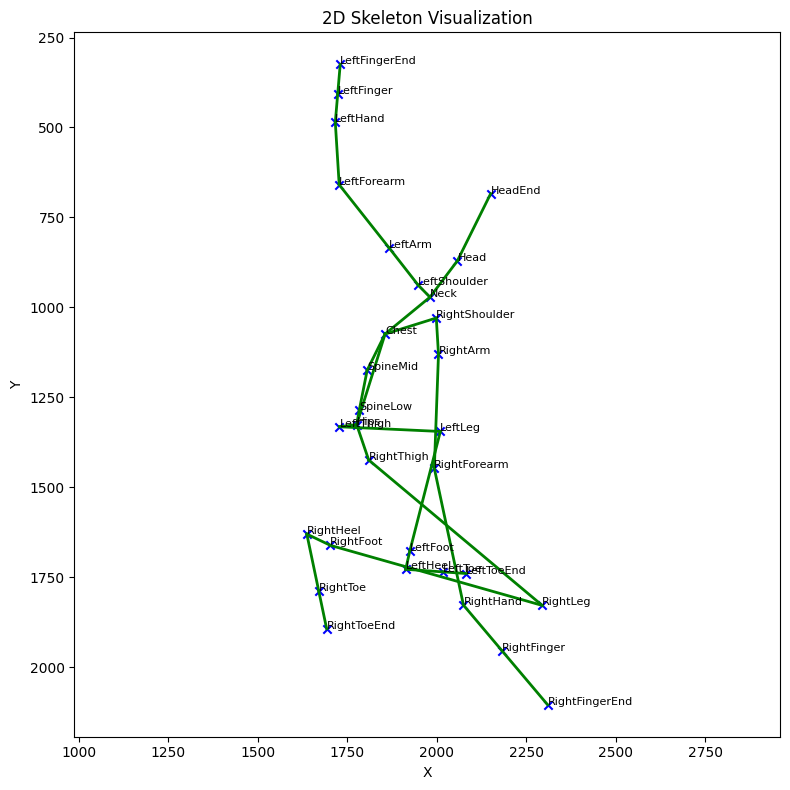

Epoch 13/20 Summary:
  Training Loss: 0.0763
  Validation Loss: 0.1319
  Model saved with validation loss: 0.1319


Epoch 14/20: 100%|██████████| 2/2 [00:07<00:00,  3.96s/it, loss=0.0935]


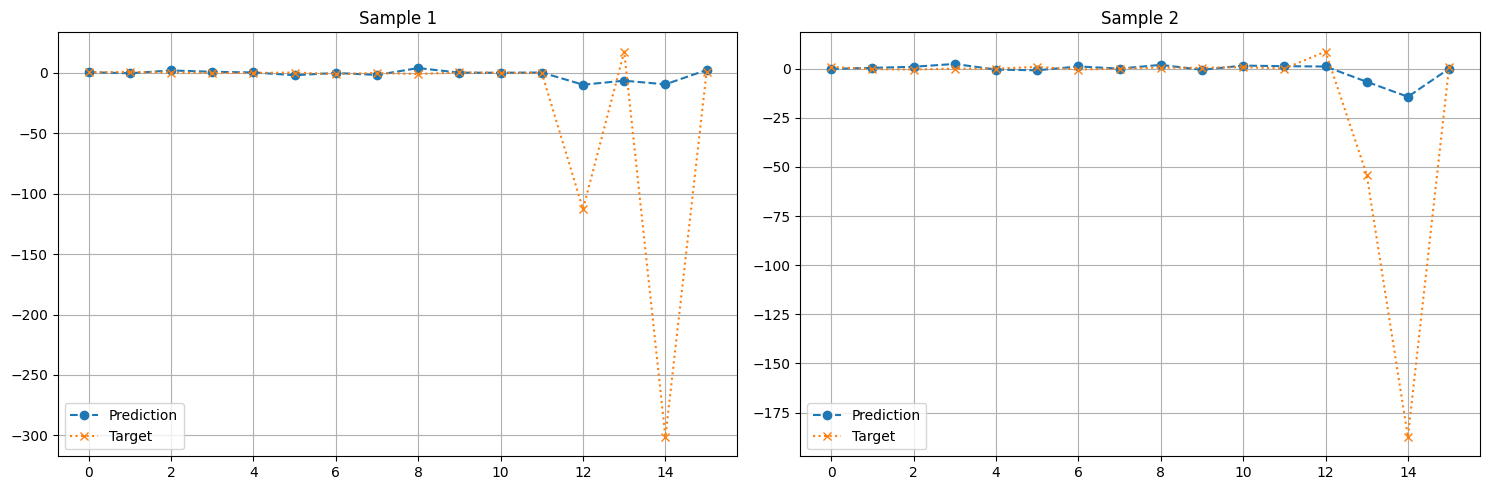

[np.float32(2058.153), np.float32(1981.5721)]
Line: Head -> Neck | Points: [np.float32(2058.153), np.float32(1981.5721)], [np.float32(870.6599), np.float32(971.6488)]
[np.float32(1981.5721), np.float32(1856.2484)]
Line: Neck -> Chest | Points: [np.float32(1981.5721), np.float32(1856.2484)], [np.float32(971.6488), np.float32(1074.105)]
[np.float32(1856.2484), np.float32(1776.7876)]
Line: Chest -> Hips | Points: [np.float32(1856.2484), np.float32(1776.7876)], [np.float32(1074.105), np.float32(1325.7881)]
[np.float32(1981.5721), np.float32(1948.6613)]
Line: Neck -> LeftShoulder | Points: [np.float32(1981.5721), np.float32(1948.6613)], [np.float32(971.6488), np.float32(938.1341)]
[np.float32(1948.6613), np.float32(1868.0879)]
Line: LeftShoulder -> LeftArm | Points: [np.float32(1948.6613), np.float32(1868.0879)], [np.float32(938.1341), np.float32(835.4595)]
[np.float32(1868.0879), np.float32(1728.0599)]
Line: LeftArm -> LeftForearm | Points: [np.float32(1868.0879), np.float32(1728.0599)], [

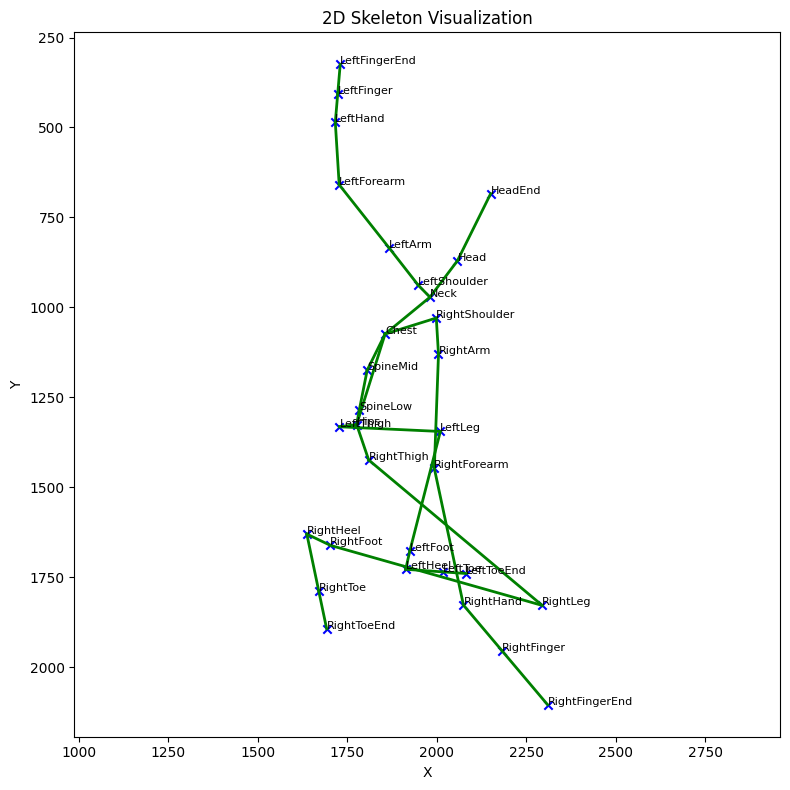

Epoch 14/20 Summary:
  Training Loss: 0.0761
  Validation Loss: 0.1316
  Model saved with validation loss: 0.1316


Epoch 15/20: 100%|██████████| 2/2 [00:08<00:00,  4.30s/it, loss=0.0929]


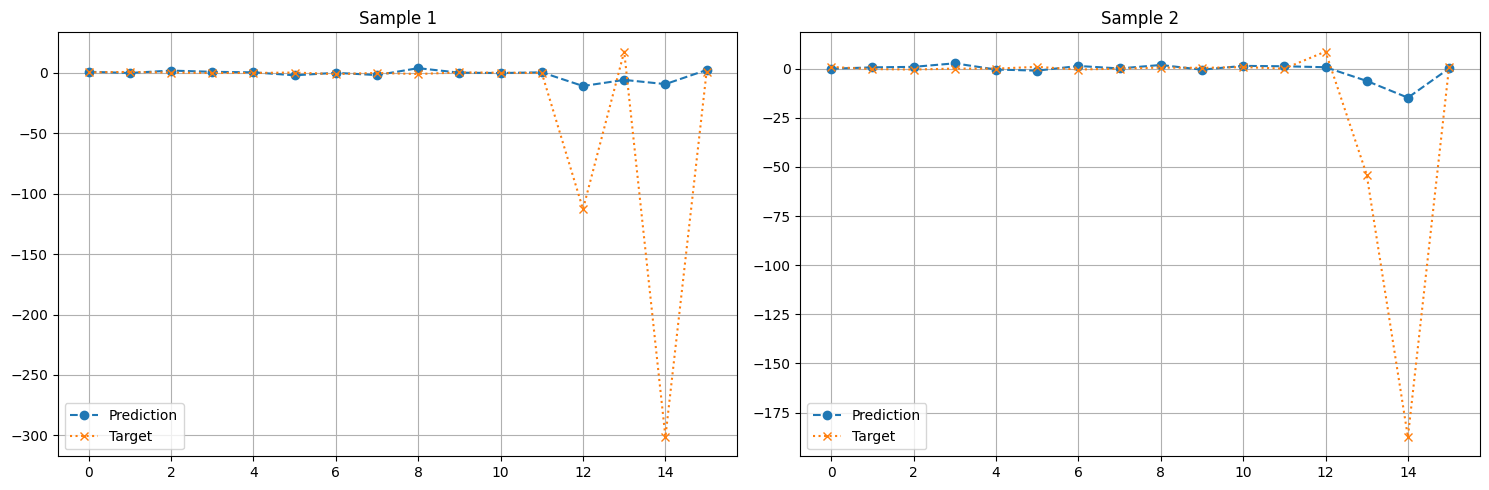

[np.float32(2058.153), np.float32(1981.5721)]
Line: Head -> Neck | Points: [np.float32(2058.153), np.float32(1981.5721)], [np.float32(870.6599), np.float32(971.6488)]
[np.float32(1981.5721), np.float32(1856.2484)]
Line: Neck -> Chest | Points: [np.float32(1981.5721), np.float32(1856.2484)], [np.float32(971.6488), np.float32(1074.105)]
[np.float32(1856.2484), np.float32(1776.7876)]
Line: Chest -> Hips | Points: [np.float32(1856.2484), np.float32(1776.7876)], [np.float32(1074.105), np.float32(1325.7881)]
[np.float32(1981.5721), np.float32(1948.6613)]
Line: Neck -> LeftShoulder | Points: [np.float32(1981.5721), np.float32(1948.6613)], [np.float32(971.6488), np.float32(938.1341)]
[np.float32(1948.6613), np.float32(1868.0879)]
Line: LeftShoulder -> LeftArm | Points: [np.float32(1948.6613), np.float32(1868.0879)], [np.float32(938.1341), np.float32(835.4595)]
[np.float32(1868.0879), np.float32(1728.0599)]
Line: LeftArm -> LeftForearm | Points: [np.float32(1868.0879), np.float32(1728.0599)], [

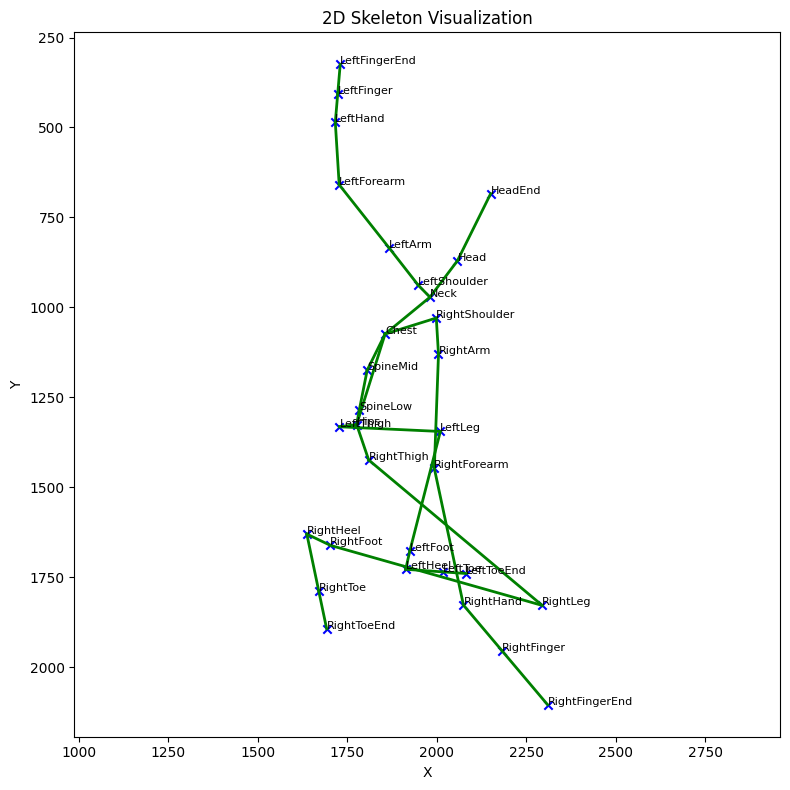

Epoch 15/20 Summary:
  Training Loss: 0.0757
  Validation Loss: 0.1313
  Model saved with validation loss: 0.1313


Epoch 16/20: 100%|██████████| 2/2 [00:07<00:00,  3.94s/it, loss=0.0931]


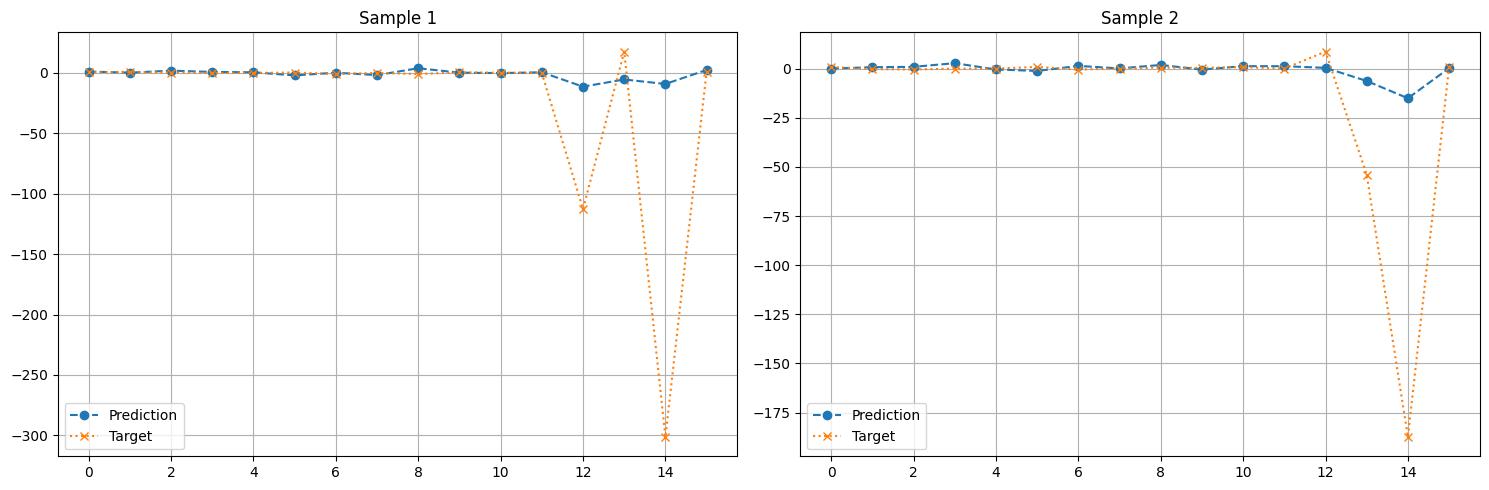

[np.float32(2058.153), np.float32(1981.5721)]
Line: Head -> Neck | Points: [np.float32(2058.153), np.float32(1981.5721)], [np.float32(870.6599), np.float32(971.6488)]
[np.float32(1981.5721), np.float32(1856.2484)]
Line: Neck -> Chest | Points: [np.float32(1981.5721), np.float32(1856.2484)], [np.float32(971.6488), np.float32(1074.105)]
[np.float32(1856.2484), np.float32(1776.7876)]
Line: Chest -> Hips | Points: [np.float32(1856.2484), np.float32(1776.7876)], [np.float32(1074.105), np.float32(1325.7881)]
[np.float32(1981.5721), np.float32(1948.6613)]
Line: Neck -> LeftShoulder | Points: [np.float32(1981.5721), np.float32(1948.6613)], [np.float32(971.6488), np.float32(938.1341)]
[np.float32(1948.6613), np.float32(1868.0879)]
Line: LeftShoulder -> LeftArm | Points: [np.float32(1948.6613), np.float32(1868.0879)], [np.float32(938.1341), np.float32(835.4595)]
[np.float32(1868.0879), np.float32(1728.0599)]
Line: LeftArm -> LeftForearm | Points: [np.float32(1868.0879), np.float32(1728.0599)], [

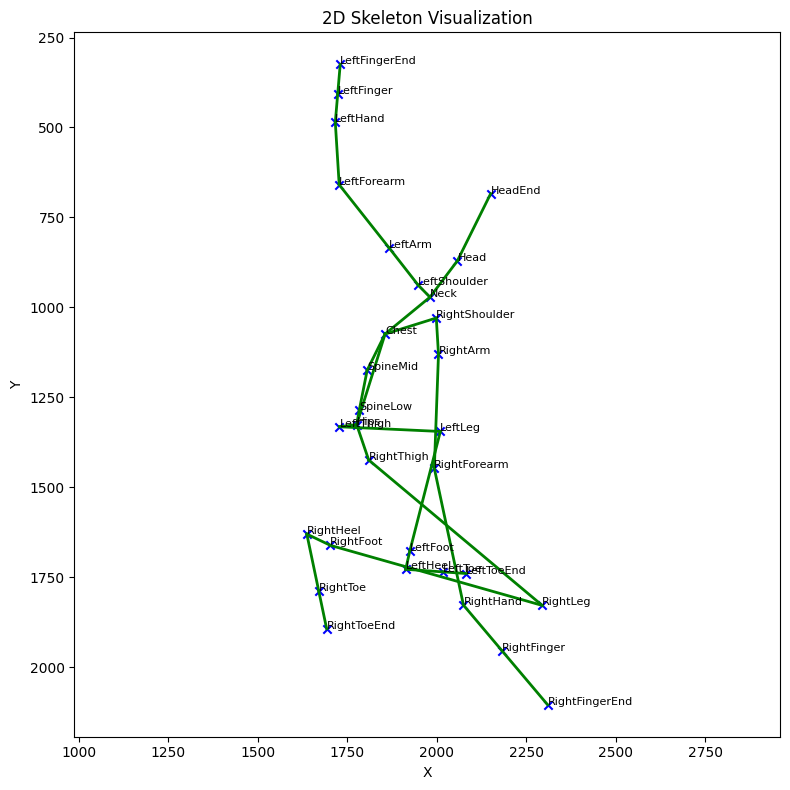

Epoch 16/20 Summary:
  Training Loss: 0.0757
  Validation Loss: 0.1312
  Model saved with validation loss: 0.1312


Epoch 17/20: 100%|██████████| 2/2 [00:07<00:00,  3.97s/it, loss=0.0946]


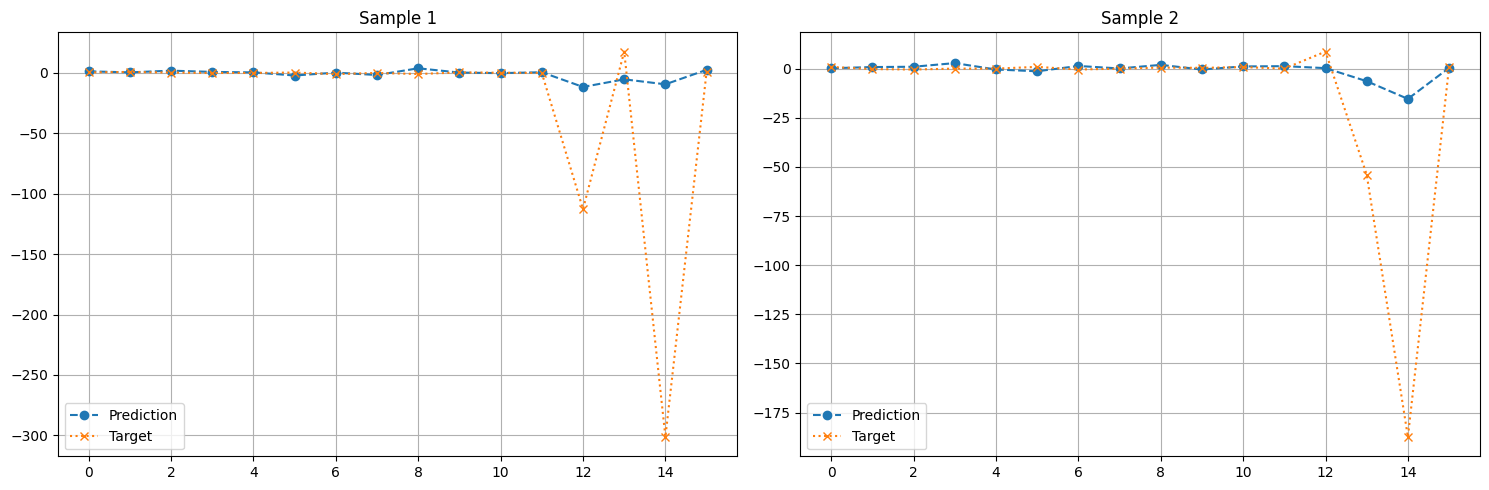

[np.float32(2058.153), np.float32(1981.5721)]
Line: Head -> Neck | Points: [np.float32(2058.153), np.float32(1981.5721)], [np.float32(870.6599), np.float32(971.6488)]
[np.float32(1981.5721), np.float32(1856.2484)]
Line: Neck -> Chest | Points: [np.float32(1981.5721), np.float32(1856.2484)], [np.float32(971.6488), np.float32(1074.105)]
[np.float32(1856.2484), np.float32(1776.7876)]
Line: Chest -> Hips | Points: [np.float32(1856.2484), np.float32(1776.7876)], [np.float32(1074.105), np.float32(1325.7881)]
[np.float32(1981.5721), np.float32(1948.6613)]
Line: Neck -> LeftShoulder | Points: [np.float32(1981.5721), np.float32(1948.6613)], [np.float32(971.6488), np.float32(938.1341)]
[np.float32(1948.6613), np.float32(1868.0879)]
Line: LeftShoulder -> LeftArm | Points: [np.float32(1948.6613), np.float32(1868.0879)], [np.float32(938.1341), np.float32(835.4595)]
[np.float32(1868.0879), np.float32(1728.0599)]
Line: LeftArm -> LeftForearm | Points: [np.float32(1868.0879), np.float32(1728.0599)], [

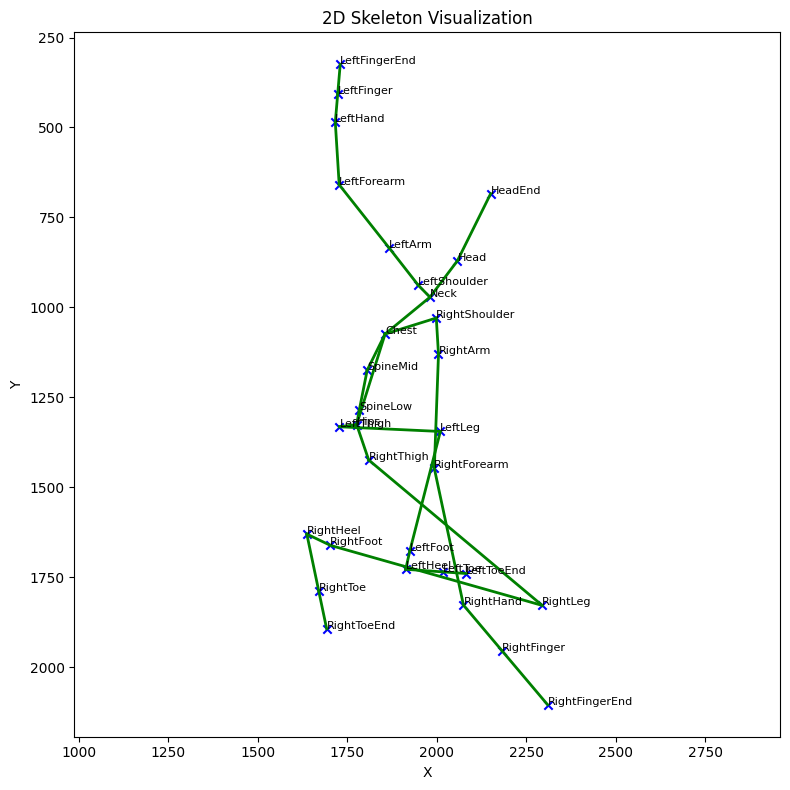

Epoch 17/20 Summary:
  Training Loss: 0.0764
  Validation Loss: 0.1311
  Model saved with validation loss: 0.1311


Epoch 18/20: 100%|██████████| 2/2 [00:07<00:00,  3.98s/it, loss=0.0923]


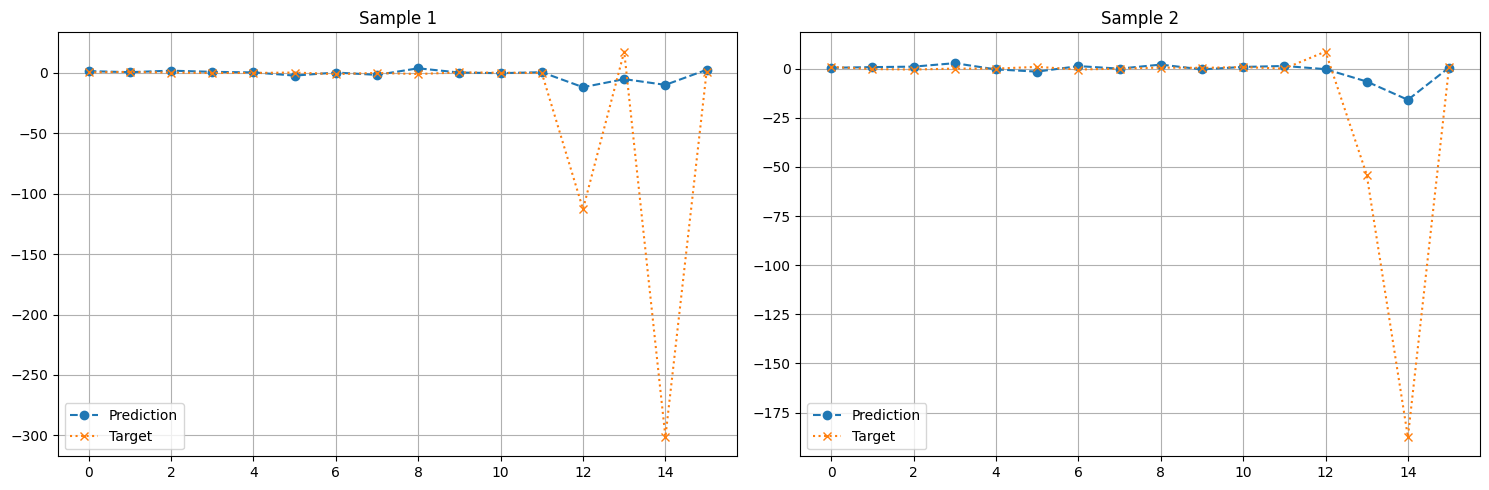

[np.float32(2058.153), np.float32(1981.5721)]
Line: Head -> Neck | Points: [np.float32(2058.153), np.float32(1981.5721)], [np.float32(870.6599), np.float32(971.6488)]
[np.float32(1981.5721), np.float32(1856.2484)]
Line: Neck -> Chest | Points: [np.float32(1981.5721), np.float32(1856.2484)], [np.float32(971.6488), np.float32(1074.105)]
[np.float32(1856.2484), np.float32(1776.7876)]
Line: Chest -> Hips | Points: [np.float32(1856.2484), np.float32(1776.7876)], [np.float32(1074.105), np.float32(1325.7881)]
[np.float32(1981.5721), np.float32(1948.6613)]
Line: Neck -> LeftShoulder | Points: [np.float32(1981.5721), np.float32(1948.6613)], [np.float32(971.6488), np.float32(938.1341)]
[np.float32(1948.6613), np.float32(1868.0879)]
Line: LeftShoulder -> LeftArm | Points: [np.float32(1948.6613), np.float32(1868.0879)], [np.float32(938.1341), np.float32(835.4595)]
[np.float32(1868.0879), np.float32(1728.0599)]
Line: LeftArm -> LeftForearm | Points: [np.float32(1868.0879), np.float32(1728.0599)], [

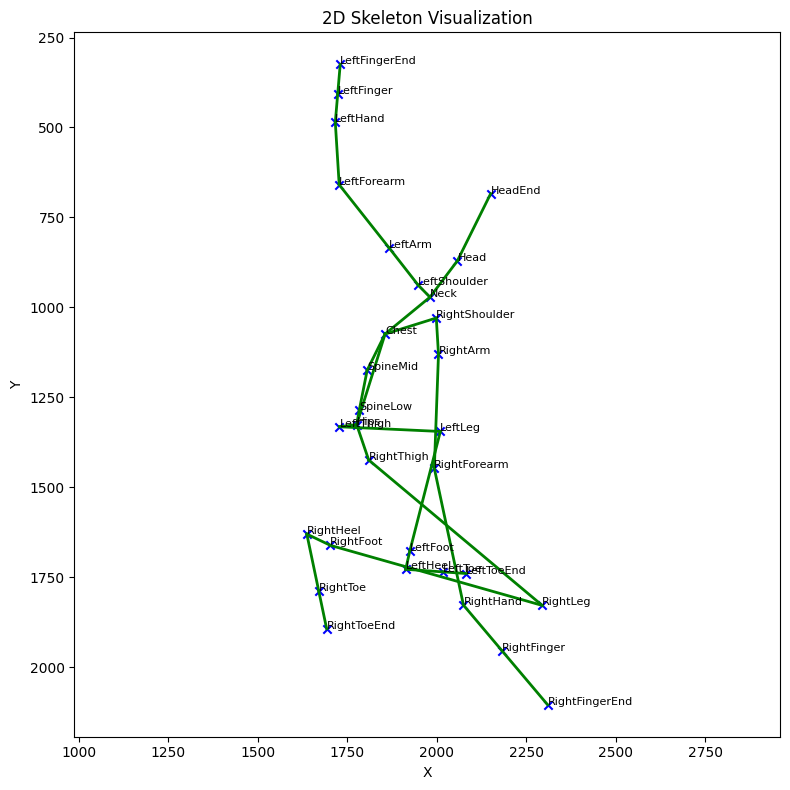

Epoch 18/20 Summary:
  Training Loss: 0.0752
  Validation Loss: 0.1309
  Model saved with validation loss: 0.1309


Epoch 19/20: 100%|██████████| 2/2 [00:07<00:00,  4.00s/it, loss=0.0918]


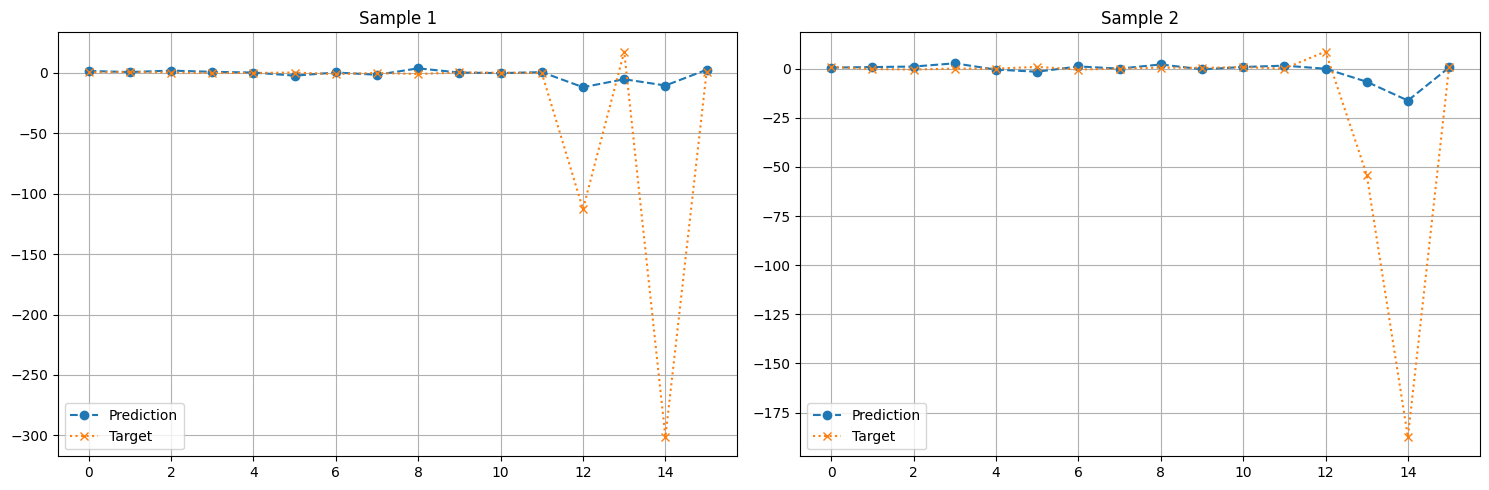

[np.float32(2058.153), np.float32(1981.5721)]
Line: Head -> Neck | Points: [np.float32(2058.153), np.float32(1981.5721)], [np.float32(870.6599), np.float32(971.6488)]
[np.float32(1981.5721), np.float32(1856.2484)]
Line: Neck -> Chest | Points: [np.float32(1981.5721), np.float32(1856.2484)], [np.float32(971.6488), np.float32(1074.105)]
[np.float32(1856.2484), np.float32(1776.7876)]
Line: Chest -> Hips | Points: [np.float32(1856.2484), np.float32(1776.7876)], [np.float32(1074.105), np.float32(1325.7881)]
[np.float32(1981.5721), np.float32(1948.6613)]
Line: Neck -> LeftShoulder | Points: [np.float32(1981.5721), np.float32(1948.6613)], [np.float32(971.6488), np.float32(938.1341)]
[np.float32(1948.6613), np.float32(1868.0879)]
Line: LeftShoulder -> LeftArm | Points: [np.float32(1948.6613), np.float32(1868.0879)], [np.float32(938.1341), np.float32(835.4595)]
[np.float32(1868.0879), np.float32(1728.0599)]
Line: LeftArm -> LeftForearm | Points: [np.float32(1868.0879), np.float32(1728.0599)], [

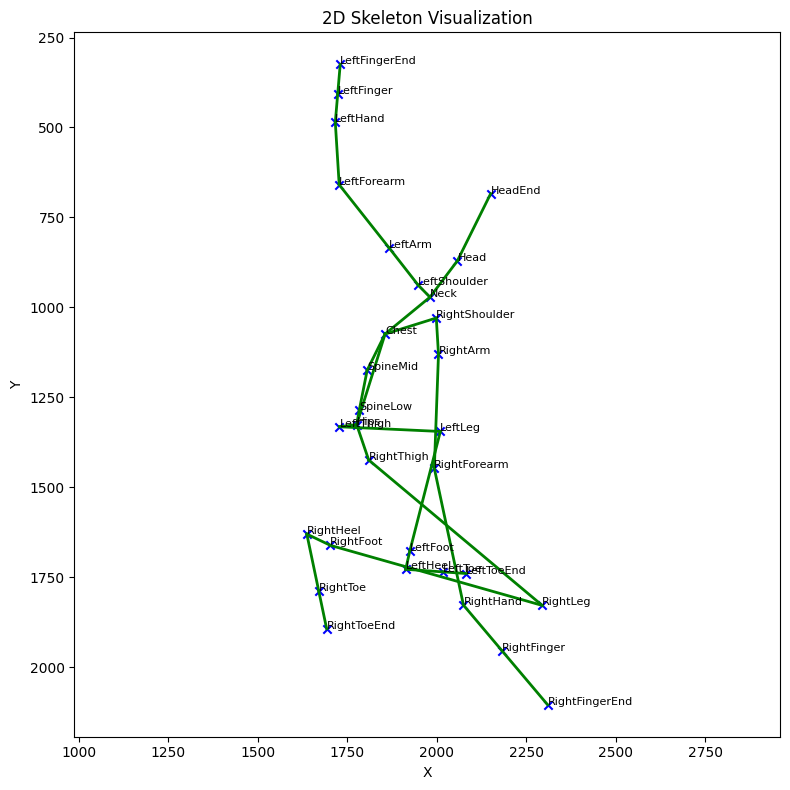

Epoch 19/20 Summary:
  Training Loss: 0.0750
  Validation Loss: 0.1308
  Model saved with validation loss: 0.1308


Epoch 20/20: 100%|██████████| 2/2 [00:08<00:00,  4.17s/it, loss=0.0918]


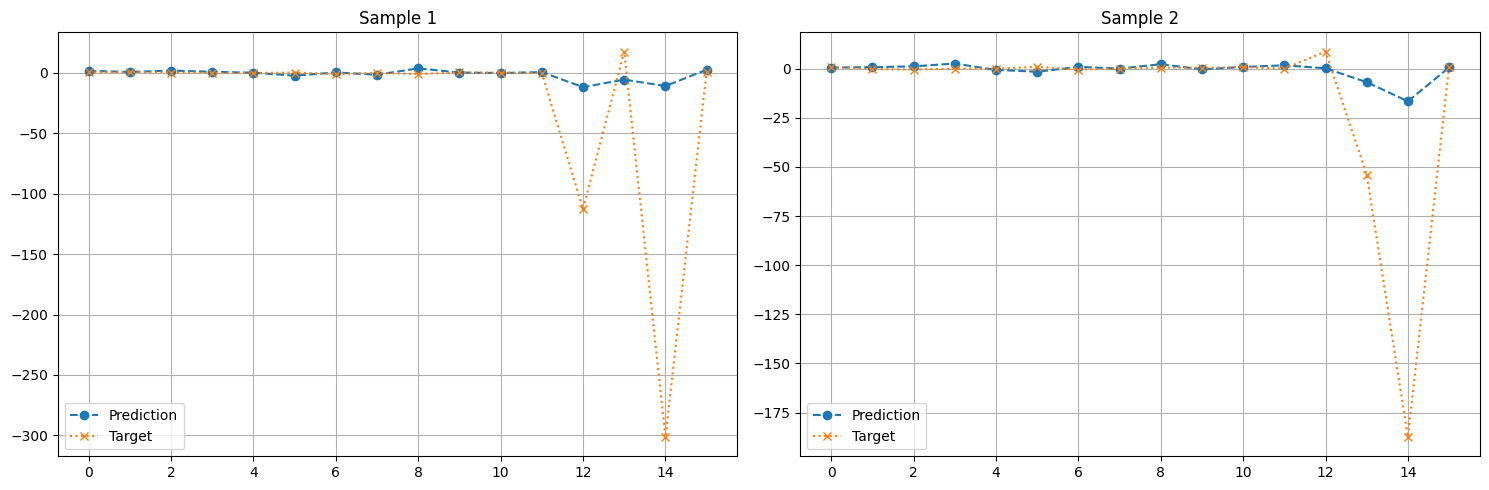

[np.float32(2058.153), np.float32(1981.5721)]
Line: Head -> Neck | Points: [np.float32(2058.153), np.float32(1981.5721)], [np.float32(870.6599), np.float32(971.6488)]
[np.float32(1981.5721), np.float32(1856.2484)]
Line: Neck -> Chest | Points: [np.float32(1981.5721), np.float32(1856.2484)], [np.float32(971.6488), np.float32(1074.105)]
[np.float32(1856.2484), np.float32(1776.7876)]
Line: Chest -> Hips | Points: [np.float32(1856.2484), np.float32(1776.7876)], [np.float32(1074.105), np.float32(1325.7881)]
[np.float32(1981.5721), np.float32(1948.6613)]
Line: Neck -> LeftShoulder | Points: [np.float32(1981.5721), np.float32(1948.6613)], [np.float32(971.6488), np.float32(938.1341)]
[np.float32(1948.6613), np.float32(1868.0879)]
Line: LeftShoulder -> LeftArm | Points: [np.float32(1948.6613), np.float32(1868.0879)], [np.float32(938.1341), np.float32(835.4595)]
[np.float32(1868.0879), np.float32(1728.0599)]
Line: LeftArm -> LeftForearm | Points: [np.float32(1868.0879), np.float32(1728.0599)], [

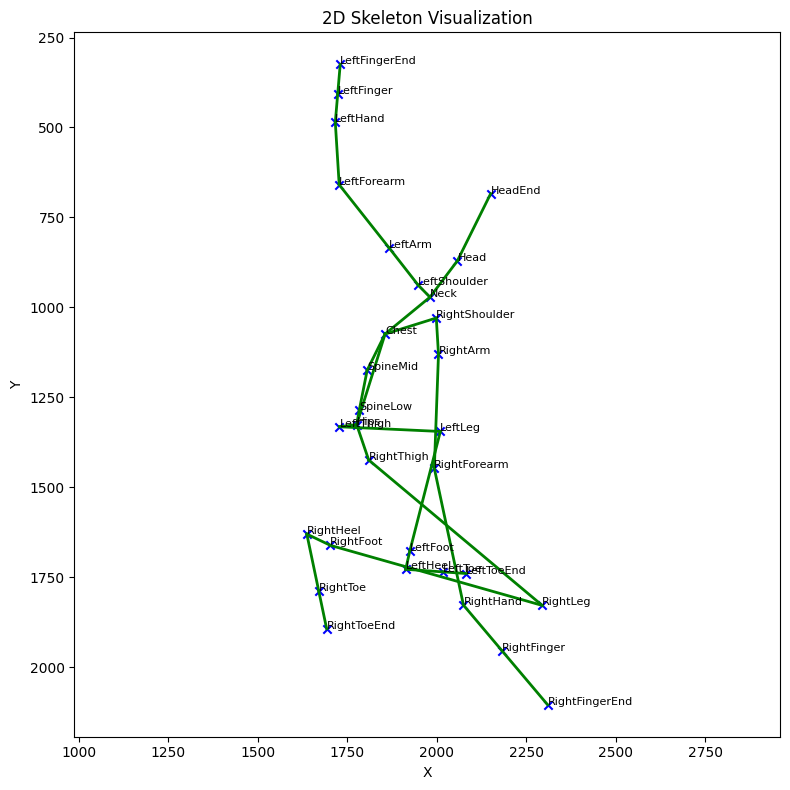

Epoch 20/20 Summary:
  Training Loss: 0.0749
  Validation Loss: 0.1306
  Model saved with validation loss: 0.1306
Loaded the best model for testing.
Test Loss: 0.0914


In [4]:
import random 

def main():
    # Configuration Parameters
    RANDOM_SEED = 100
    data_fraction = 0.001  # Use only 1% of the data
    BATCH_SIZE = 256
    LEARNING_RATE = 5e-5
    EPOCHS = 20
    NUM_WORKERS = 0
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    MODEL_SAVE_PATH = "ktpformer_best_model.pth"
    TRAIN_SIZE = 0.7
    VAL_SIZE = 0.1
    TEST_SIZE = 0.2
    EARLY_STOP_PATIENCE = 5
    VIZUALIZE_EVERY = 1

    torch.manual_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)
    if DEVICE == 'cuda':
        torch.cuda.manual_seed(RANDOM_SEED)

    load_dotenv()
    uri = os.getenv('URI')
    if not uri:
        raise EnvironmentError("Please set the 'URI' environment variable in your .env file.")

    # Skeleton configuration
    connections = [
        ('Head', 'Neck'), ('Neck', 'Chest'), ('Chest', 'Hips'),
        ('Neck', 'LeftShoulder'), ('LeftShoulder', 'LeftArm'),
        ('LeftArm', 'LeftForearm'), ('LeftForearm', 'LeftHand'),
        ('Chest', 'RightShoulder'), ('RightShoulder', 'RightArm'),
        ('RightArm', 'RightForearm'), ('RightForearm', 'RightHand'),
        ('Hips', 'LeftThigh'), ('LeftThigh', 'LeftLeg'),
        ('LeftLeg', 'LeftFoot'), ('Hips', 'RightThigh'),
        ('RightThigh', 'RightLeg'), ('RightLeg', 'RightFoot'),
        ('RightHand', 'RightFinger'), ('RightFinger', 'RightFingerEnd'),
        ('LeftHand', 'LeftFinger'), ('LeftFinger', 'LeftFingerEnd'),
        ('Head', 'HeadEnd'), ('RightFoot', 'RightHeel'),
        ('RightHeel', 'RightToe'), ('RightToe', 'RightToeEnd'),
        ('LeftFoot', 'LeftHeel'), ('LeftHeel', 'LeftToe'),
        ('LeftToe', 'LeftToeEnd'),
        ('SpineLow', 'Hips'), ('SpineMid', 'SpineLow'), ('Chest', 'SpineMid')
    ]

    joints_left = [
        'LeftShoulder', 'LeftArm', 'LeftForearm', 'LeftHand', 'LeftFinger', 'LeftFingerEnd',
        'LeftThigh', 'LeftLeg', 'LeftFoot', 'LeftHeel', 'LeftToe', 'LeftToeEnd'
    ]

    joints_right = [
        'RightShoulder', 'RightArm', 'RightForearm', 'RightHand', 'RightFinger', 'RightFingerEnd',
        'RightThigh', 'RightLeg', 'RightFoot', 'RightHeel', 'RightToe', 'RightToeEnd'
    ]

    uri = os.getenv('URI')
    dataset = MocapDataset(uri=uri, db_name='ai', collection_name='cameraPoses', skeleton=None)

    labels = dataset.joint_names 

    skeleton = Skeleton(
        connections=connections,
        joints_left=joints_left,
        joints_right=joints_right,
        ordered_joint_names=labels
    )

    dataset.skeleton = skeleton

    total_samples = len(dataset)
    samples_to_use = int(total_samples * data_fraction)
    samples_to_use = max(1, samples_to_use)
    dataset._ids = dataset._ids[:samples_to_use]
    dataset.total = samples_to_use

    print(f"Data Fraction: {data_fraction}, Using {samples_to_use} samples out of {total_samples}.")
    print(f"Number of joints: {dataset.num_joints}")
    print(f"Joint names: {dataset.joint_names}")

    sanity_check(dataset)

    split_generator = torch.Generator().manual_seed(RANDOM_SEED)

    train_length = int(TRAIN_SIZE * len(dataset))
    val_length = int(VAL_SIZE * len(dataset))
    test_length = len(dataset) - train_length - val_length

    train_dataset, val_dataset, test_dataset = random_split(
        dataset,
        [train_length, val_length, test_length],
        generator=split_generator
    )

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Testing samples: {len(test_dataset)}")

    loader_generator = torch.Generator().manual_seed(RANDOM_SEED)
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,  
        pin_memory=True,
        generator=loader_generator
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,  
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,  
        pin_memory=True
    )

    adj_matrix = adj_mx_from_skeleton(skeleton)
    model = KTPFormer(
        input_dim=dataset.num_joints * 2,
        embed_dim=256,
        adj=adj_matrix,
        depth=2,
        disable_tpa=True
    ).to(DEVICE)

    model.apply(initialize_weights)

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
    scaler = GradScaler() if DEVICE == 'cuda' else None

    def validate(show_visualization=True,skeleton = skeleton):
        model.eval()
        val_loss = 0.0
        first_batch_outputs = None
        first_batch_targets = None
        first_batch_inputs = None

        with torch.no_grad():
            for i, (keypoints, camera_matrix,_,_) in enumerate(val_loader):
                keypoints, camera_matrix  = keypoints.to(DEVICE), camera_matrix.to(DEVICE) 
                with torch.amp.autocast(device_type='cuda', enabled=(DEVICE == 'cuda')):
                    outputs = model(keypoints)
                    loss = weighted_frobenius_loss(outputs, camera_matrix)
                val_loss += loss.item()

                if i == 0 and show_visualization:
                    first_batch_inputs = keypoints.detach().cpu().numpy()
                    first_batch_outputs = outputs.detach().cpu().numpy()
                    first_batch_targets = camera_matrix.detach().cpu().numpy()

        val_loss /= len(val_loader)

        if show_visualization and first_batch_outputs is not None and first_batch_targets is not None:
            visualize_predictions(first_batch_outputs, first_batch_targets)
            #random = random.random()
            visualize_keypoint_skeleton(first_batch_inputs[5],skeleton=skeleton)

        return val_loss

    def train_model():
        best_val_loss = float('inf')
        no_improvement_count = 0

        for epoch in range(EPOCHS):
            model.train()
            total_loss = 0.0
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=True)

            for batch_idx, (keypoints, camera_matrix , _ , _) in enumerate(progress_bar):
                keypoints, camera_matrix = keypoints.to(DEVICE), camera_matrix.to(DEVICE)
                optimizer.zero_grad()

                with torch.amp.autocast(device_type='cuda', enabled=(DEVICE == 'cuda')):
                    outputs = model(keypoints)
                    loss = weighted_frobenius_loss(outputs, camera_matrix)

                if scaler is not None:
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    optimizer.step()

                total_loss += loss.item()
                progress_bar.set_postfix(loss=loss.item())

            scheduler.step()

            show_viz = (epoch % VIZUALIZE_EVERY == 0)
            val_loss = validate(show_visualization=show_viz,skeleton=skeleton)

            avg_train_loss = total_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{EPOCHS} Summary:")
            print(f"  Training Loss: {avg_train_loss:.4f}")
            print(f"  Validation Loss: {val_loss:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improvement_count = 0
                torch.save(model.state_dict(), MODEL_SAVE_PATH)
                print(f"  Model saved with validation loss: {best_val_loss:.4f}")
            else:
                no_improvement_count += 1
                if no_improvement_count >= EARLY_STOP_PATIENCE:
                    print(f"No improvement for {EARLY_STOP_PATIENCE} validation checks. Early stopping.")
                    break

    def test_model():
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for keypoints, camera_matrix , _ , _ in test_loader:
                keypoints, camera_matrix = keypoints.to(DEVICE), camera_matrix.to(DEVICE)
                with torch.amp.autocast(device_type='cuda', enabled=(DEVICE == 'cuda')):
                    outputs = model(keypoints)
                    loss = weighted_frobenius_loss(outputs, camera_matrix)
                test_loss += loss.item()
        test_loss /= len(test_loader)
        print(f"Test Loss: {test_loss:.4f}")

    train_model()

    model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    print("Loaded the best model for testing.")

    test_model()

if __name__ == "__main__":
    main()